In [1]:
import pandas as pd
import plotnine as p9
from pathlib import Path
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotnine as p9

In [2]:
results_dir = "../../data/processed/results"
samples = [f.stem for f in Path(results_dir).iterdir()]
libraries = {sample: [f.stem.split("_")[2] for f in (Path(results_dir)/sample).glob('*counts*.txt')]
            for sample in samples}
library_to_mapping_file = {}

FileNotFoundError: [Errno 2] No such file or directory: '../../data/processed/results'

In [138]:
samples

['dnaid2016',
 'dnaid2015',
 'dnaid2030',
 'dnaid2029',
 'dnaid2028',
 'dnaid2027',
 'dnaid2026',
 'dnaid2025',
 'dnaid2019',
 'dnaid2023',
 'dnaid2017',
 'dnaid2024']

In [214]:

results_dir = "../../data/processed/results"
controls = pd.read_table('../../data/metadata/controls.txt', header=None, 
                        names = ['DN', 'barcode', 'phenotype', 'conc'])
meta_dir = "../../data/metadata"


def read_count_files(sample, exp, results_dir=results_dir):
    df = pd.read_table(Path(results_dir)/f'{sample}/{sample}_counts_{exp}.txt', sep=" ").assign(exp=exp)
    df = (df.reset_index().rename({'index':'barcode'}, axis=1)
          .melt(id_vars=['barcode','Position', 'Element', 'Strand', 'Feature', 'ShortName', 'exp']))
    df['proportion'] = df['value']/ df.groupby('variable')['value'].transform('sum')
    expansion = df['variable'].str.split('-', expand=True)
    df['mouse'], df['day'],df['organ'] = expansion[0], expansion[1], expansion[2]
    df = df.rename({'variable':'sample', 'value':'cnts'}, axis=1)
    return df


def load_sample(sample, meta_dir = meta_dir, results_dir = results_dir):
    meta = (pd.read_table(Path(meta_dir)/f'{sample}_metadata.txt', header=None, 
                        names = ['DN', 'lib', 'exp', 'DN2', 'sample', 'day', 'organ']).drop(['DN', 'DN2'], axis=1))
            
    exps = meta.exp.unique()
    dfs = [read_count_files(sample, exp) for exp in exps]
    fdf = pd.concat(dfs).assign(dnaid=sample)
    #fdf = fdf.merge(meta[['lib', 'exp']], how='left', left_on='exp', right_on='exp')
    return fdf


def load_samples(samples, meta_dir=meta_dir, results_dir=results_dir):
    dfs = [load_sample(sample, meta_dir, results_dir) for sample in samples]
    return pd.concat(dfs)


# Load all the count data for specified dnaids. 

fdf = load_samples(samples)

gene_info = fdf[['Feature', 'ShortName']].drop_duplicates().set_index('Feature')



def load_meta(sample, meta_dir = meta_dir, results_dir = results_dir):
    meta = (pd.read_table(Path(meta_dir)/f'{sample}_metadata.txt', header=None, 
                        names = ['DN', 'lib', 'exp', 'DN2', 'sample', 'day', 'organ']).drop(['DN', 'DN2'], axis=1))
    
    return meta
            
def load_all_meta(samples, meta_dir=meta_dir, results_dir=results_dir):
    dfs = [load_meta(sample, meta_dir, results_dir) for sample in samples]
    return pd.concat(dfs)
            
meta = load_all_meta(samples)
meta_dict = meta[['lib', 'exp']].set_index('exp').to_dict()
meta_dict = meta_dict['lib']
meta_dict

{'TV4570': 'library_10_1',
 'TV5652': 'library_12_2',
 'TV5585A': 'library_10_2',
 'TV5585B': 'library_12_1',
 'TV5585C': 'library_12_2',
 'TV5563A': 'library_10_2',
 'TV5563B': 'library_12_2',
 'TV5536C': 'library_15_1',
 'TV5536A': 'library_9_1',
 'TV5536B': 'library_14_2',
 'TV4518': 'library_11_2',
 'TV5490A': 'library_13_1',
 'TV5490B': 'library_13_2',
 'TV5490C': 'library_14_2',
 'TV4592A': 'library_10_2',
 'TV4592B': 'library_14_2'}

In [226]:
fdf['lib'] = fdf.exp.replace(meta_dict)
new = fdf[(fdf.barcode =='ATGGCCAGCCAATCTAG') & (fdf.ShortName == 'hilD') & (fdf.mouse == 'inoculum')]

new[['barcode', 'ShortName', 'cnts', 'lib', 'dnaid']].drop_duplicates()

barcode ShortName   cnts           lib      dnaid
1978   ATGGCCAGCCAATCTAG      hilD     60  library_10_2  dnaid2029
3761   ATGGCCAGCCAATCTAG      hilD     51  library_10_2  dnaid2028
5477   ATGGCCAGCCAATCTAG      hilD    354  library_10_2  dnaid2027
3338   ATGGCCAGCCAATCTAG      hilD  11306  library_15_1  dnaid2026
12020  ATGGCCAGCCAATCTAG      hilD  10616  library_15_1  dnaid2025
5061   ATGGCCAGCCAATCTAG      hilD    250  library_13_1  dnaid2023
4717   ATGGCCAGCCAATCTAG      hilD    347  library_13_1  dnaid2024

In [182]:
df = fdf[ (fdf.mouse == 'inoculum')& (fdf.cnts > 1000)][['barcode', 'Position', 'Element','Feature','exp', 'dnaid', 'cnts']]
# df has all barcodes for all libraries where mouse == inoculum and counts are > 1000. 
df['lib'] = df.exp.replace(meta_dict)

df.head()

barcode   Position      Element           Feature     exp  \
135522  AAAAAACTGATACAAAG  3049115.0   FQ312003.1  gene-SL1344_2861  TV4570   
135525  AAAACAACCGAGACTAA  3763599.0   FQ312003.1  gene-SL1344_3540  TV4570   
135528  AAAACACCGGTGACCAT  3677559.0   FQ312003.1  gene-SL1344_3466  TV4570   
135532  AAAACCACGAACGTTAC  2169771.0   FQ312003.1  gene-SL1344_2067  TV4570   
135537  AAAACGCAGCGCTTGCC    65692.0  NC_017720.1                 -  TV4570   

            dnaid  cnts           lib  
135522  dnaid2016  1777  library_10_1  
135525  dnaid2016  4472  library_10_1  
135528  dnaid2016  2798  library_10_1  
135532  dnaid2016  3260  library_10_1  
135537  dnaid2016  4861  library_10_1

In [147]:
map_dir = "/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/"\
                "chris/hardt/nguyenb/tnseq_mapping_2031/scratch/"


def get_library(mapping_file):
    library = pd.read_table(mapping_file, header=None, index_col=0, names=['lib_counts', 'position', 'chr',
                                                                          'strand', 'norm_count', 'locus', 'gene'])
    library['library'] = Path(mapping_file).parent.stem
    return library

def all_libraries(mapping_dir):
    files = [c/"barcode_map.txt" for c in Path(map_dir).iterdir()]
    df_list = [ get_library(f) for f in files] 
    return pd.concat(df_list)


all_lib = all_libraries(map_dir)
all_lib = all_lib.reset_index().rename({'index':'barcode'}, axis=1)
all_lib.sample(5)

barcode  lib_counts  position         chr strand  \
135676  CAAACAAAATTAGAATC           1   2344254  FQ312003.1   plus   
551620  TGAACTGGTACTAATAG           2   2894110  FQ312003.1   plus   
413300  GCATACACTAGACAGCC        7903   4777734  FQ312003.1  minus   
204900  TATAGAATAATTTACGC           4   4635532  FQ312003.1   plus   
170581  AATAGTCTGGTTGAAAC          13    982186  FQ312003.1  minus   

         norm_count locus gene       library  
135676     1.000000     -    -  library_11_2  
551620     2.000000     -    -   library_9_1  
413300  6832.500000     -    -  library_15_2  
204900     4.000000     -    -  library_13_1  
170581     1.714286     -    -  library_12_2

In [152]:
df.head()

barcode   Position      Element           Feature     exp  \
135522  AAAAAACTGATACAAAG  3049115.0   FQ312003.1  gene-SL1344_2861  TV4570   
135525  AAAACAACCGAGACTAA  3763599.0   FQ312003.1  gene-SL1344_3540  TV4570   
135528  AAAACACCGGTGACCAT  3677559.0   FQ312003.1  gene-SL1344_3466  TV4570   
135532  AAAACCACGAACGTTAC  2169771.0   FQ312003.1  gene-SL1344_2067  TV4570   
135537  AAAACGCAGCGCTTGCC    65692.0  NC_017720.1                 -  TV4570   

            dnaid  cnts           lib  
135522  dnaid2016  1777  library_10_1  
135525  dnaid2016  4472  library_10_1  
135528  dnaid2016  2798  library_10_1  
135532  dnaid2016  3260  library_10_1  
135537  dnaid2016  4861  library_10_1

In [150]:
all_lib.shape

(594941, 9)

In [164]:
lib_barcodes = {}
lib_mapping_bc = {}
for i, g in df.groupby('lib'):
    mapping_bc = set(all_lib[all_lib.library == i].barcode.values)
    inoculum_bc = set(g.barcode.values)
    #print(len(set(g.barcode.values)))
    #print(len(set(all_lib[all_lib.library == i].barcode.values)))
    barcodes = inoculum_bc.intersection(mapping_bc)
    #print(len(barcodes))
    lib_barcodes[i] = barcodes
    lib_mapping_bc[i] = mapping_bc

In [155]:
for k,v in lib_barcodes.items():
    print(k)
    print(len(v))

library_10_1
1997
library_10_2
2055
library_11_2
1405
library_12_1
1701
library_12_2
1767
library_13_1
1533
library_13_2
1530
library_14_2
1780
library_15_1
1592
library_9_1
1774


In [161]:
len(lib_barcodes['library_12_1'].intersection(lib_barcodes['library_10_2']))

0

In [174]:
hc_df = []
for i, g in all_lib.groupby('library'):
    if not i in lib_barcodes.keys():
        continue
    df = g[g.barcode.isin(lib_barcodes[i])]
    hc_df.append(df)
lib_hi = pd.concat(hc_df)

In [178]:
lib_hi.head()

barcode  lib_counts  position          chr strand    norm_count  \
0  CGCCCGCCCAGTTATTC       88513       452  NC_017719.1  minus  80260.333333   
1  TAAGGCCCCAATCGTGC       86827      6881  NC_017719.1  minus  78743.250000   
2  GTTGAATTTCGACGCCA       77612      8103  NC_017719.1  minus  70201.083333   
3  ATTGGATTACAGAACAC       68110        98  NC_017719.1  minus  62160.000000   
4  AGAATGCCAACAATATG       34738      7814  NC_017719.1   plus  31117.250000   

                 locus            gene       library  
0  gene-SL1344_RS24690            sul2  library_10_1  
1  gene-SL1344_RS24725  SL1344_RS24725  library_10_1  
2  gene-SL1344_RS24735     aph(3'')-Ib  library_10_1  
3  gene-SL1344_RS24690            sul2  library_10_1  
4  gene-SL1344_RS24730  SL1344_RS24730  library_10_1

In [165]:
len(lib_mapping_bc['library_12_1'].intersection(lib_mapping_bc['library_10_2']))

4013

In [186]:
lib_hi.head()

barcode  lib_counts  position          chr strand    norm_count  \
0  CGCCCGCCCAGTTATTC       88513       452  NC_017719.1  minus  80260.333333   
1  TAAGGCCCCAATCGTGC       86827      6881  NC_017719.1  minus  78743.250000   
2  GTTGAATTTCGACGCCA       77612      8103  NC_017719.1  minus  70201.083333   
3  ATTGGATTACAGAACAC       68110        98  NC_017719.1  minus  62160.000000   
4  AGAATGCCAACAATATG       34738      7814  NC_017719.1   plus  31117.250000   

                 locus            gene       library  
0  gene-SL1344_RS24690            sul2  library_10_1  
1  gene-SL1344_RS24725  SL1344_RS24725  library_10_1  
2  gene-SL1344_RS24735     aph(3'')-Ib  library_10_1  
3  gene-SL1344_RS24690            sul2  library_10_1  
4  gene-SL1344_RS24730  SL1344_RS24730  library_10_1

/nfs/home/ansintsova/miniconda3/envs/datavis/lib/python3.9/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log10


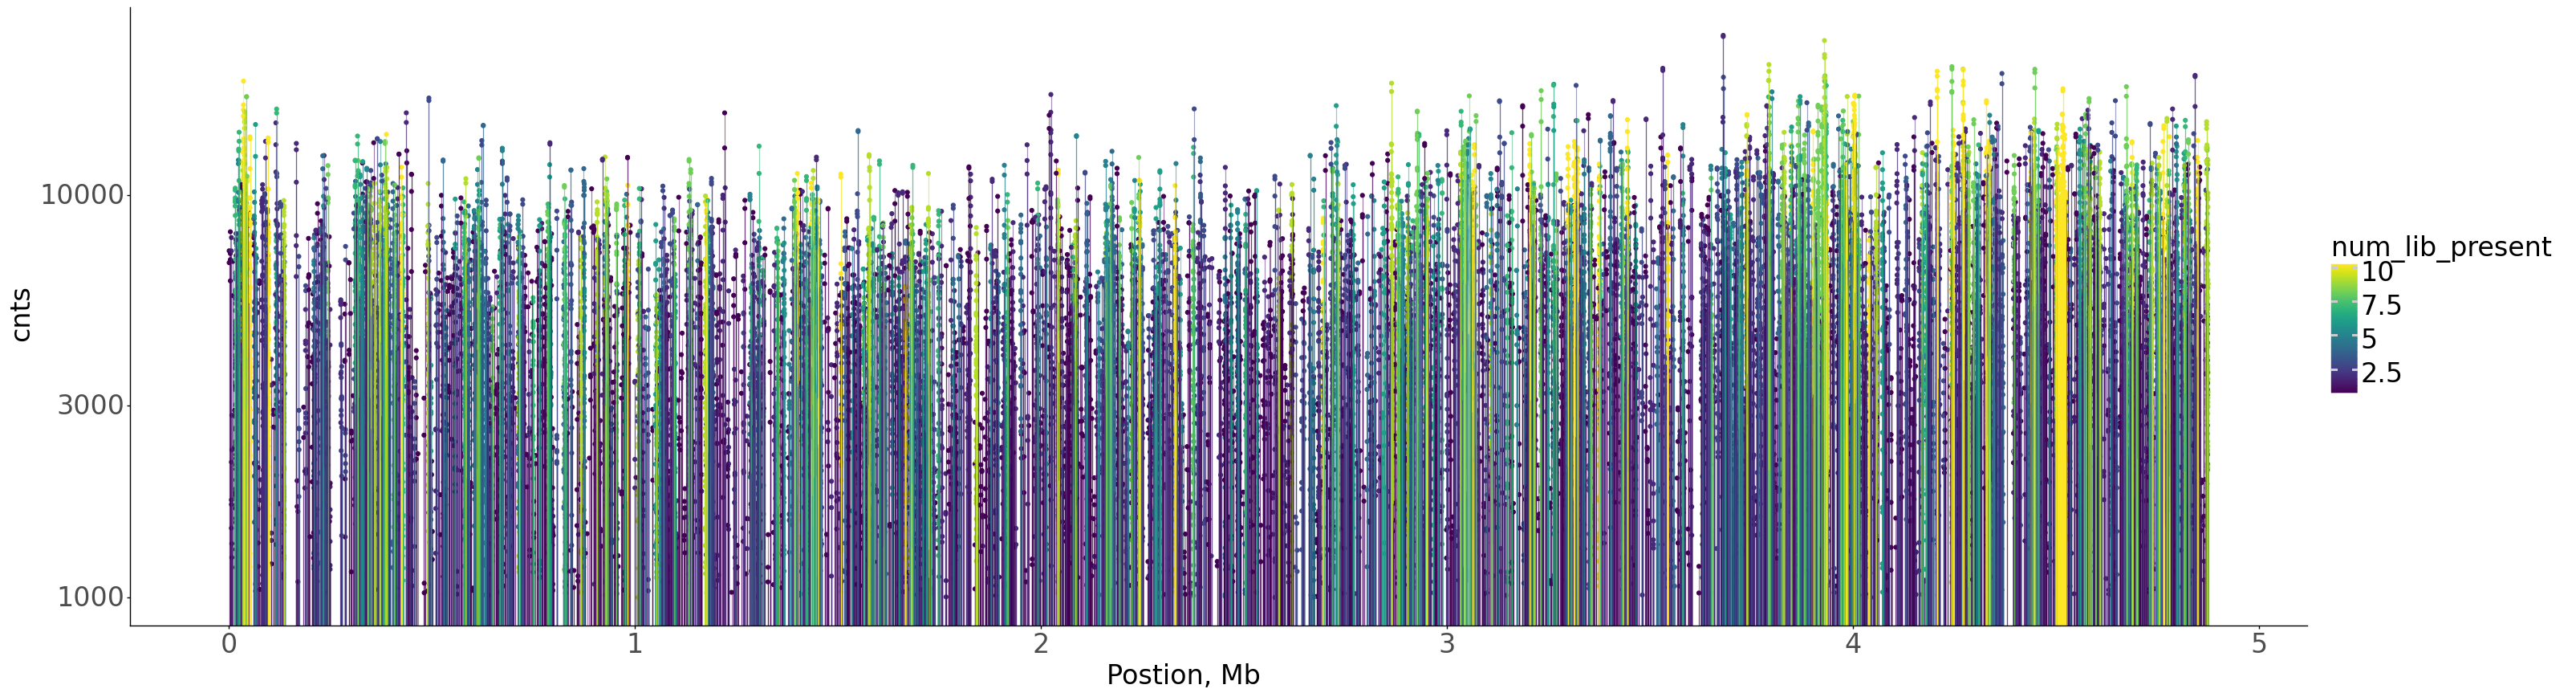

<ggplot: (2992886880344)>

In [185]:
df.Element.unique() # Chromosome and 3 plasmids


def vis_library_insertions(df, element= 'FQ312003.1', div=1000000, unit='Mb'):
    ldf = df[df['Element'] == element]

    # Only interested in annotated insertions
    ldf = ldf[ldf.Feature != '-']
    per_gene_summary = ldf.groupby(['Feature']).agg({'barcode':'nunique',  'lib':'nunique'}).reset_index()
    per_gene_summary.columns = ['Feature',  'barcode_uniq','num_lib_present']
    fdf = ldf.merge(per_gene_summary[['Feature','barcode_uniq','num_lib_present']], how= 'left',on='Feature')
    fdf['Position'] = fdf['Position']/div
    p9.options.figure_size = (35, 10)
    g = (p9.ggplot(fdf, p9.aes(x='Position', y='cnts', color='num_lib_present'))
     #+ p9.geom_line()
     + p9.geom_point()
     + p9.geom_segment(p9.aes(x='Position', xend='Position', y='cnts', yend=0), alpha=0.5)
     + p9.theme_classic()
     + p9.theme(text = p9.element_text(size=24))
    # + p9.ylab("Count")
      + p9.xlab(f"Postion, {unit}")
      + p9.scale_y_log10())
     #+ p9.scale_color_distiller(palette=1, ))
    #  + p9.facet_wrap('~ sample'))
    return fdf, g
# to_plot = lib_sum.groupby(['Position']).agg({'lib':'nunique', 'cnts':'mean', 'barcode':'nunique'}).reset_index()
# to_plot['Position'] = to_plot['Position']/1000000
# to_plot.tail()




ldf, g = vis_library_insertions(df)
g


In [197]:
ldf = lib_hi[lib_hi['chr'] == 'FQ312003.1']

    
ldf = ldf[ldf.locus != '-']
per_gene_summary = ldf.groupby(['locus']).agg({'barcode':'nunique',  'library':'nunique'}).reset_index()
per_gene_summary.columns = ['locus',  'barcode_uniq','num_lib_present']
fdf = ldf.merge(per_gene_summary[['locus','barcode_uniq','num_lib_present']], how= 'left',on='locus')
fdf['position'] = fdf['position']/1000000
p9.options.figure_size = (40, 10)
g = (p9.ggplot(fdf, p9.aes(x='position', y='lib_counts', color='num_lib_present'))
 #+ p9.geom_line()
 + p9.geom_point()
 + p9.geom_segment(p9.aes(x='position', xend='position', y='lib_counts', yend=0), alpha=0.5)
 + p9.theme_classic()
 + p9.theme(text = p9.element_text(size=24))
    # + p9.geom_vline(fdf, p9.aes(xintercept =4.105675 ), linetype="dashed",  size=5)
# + p9.ylab("Count")
  + p9.xlab(f"Postion, Mb")
  + p9.scale_y_log10())

/nfs/home/ansintsova/miniconda3/envs/datavis/lib/python3.9/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log10


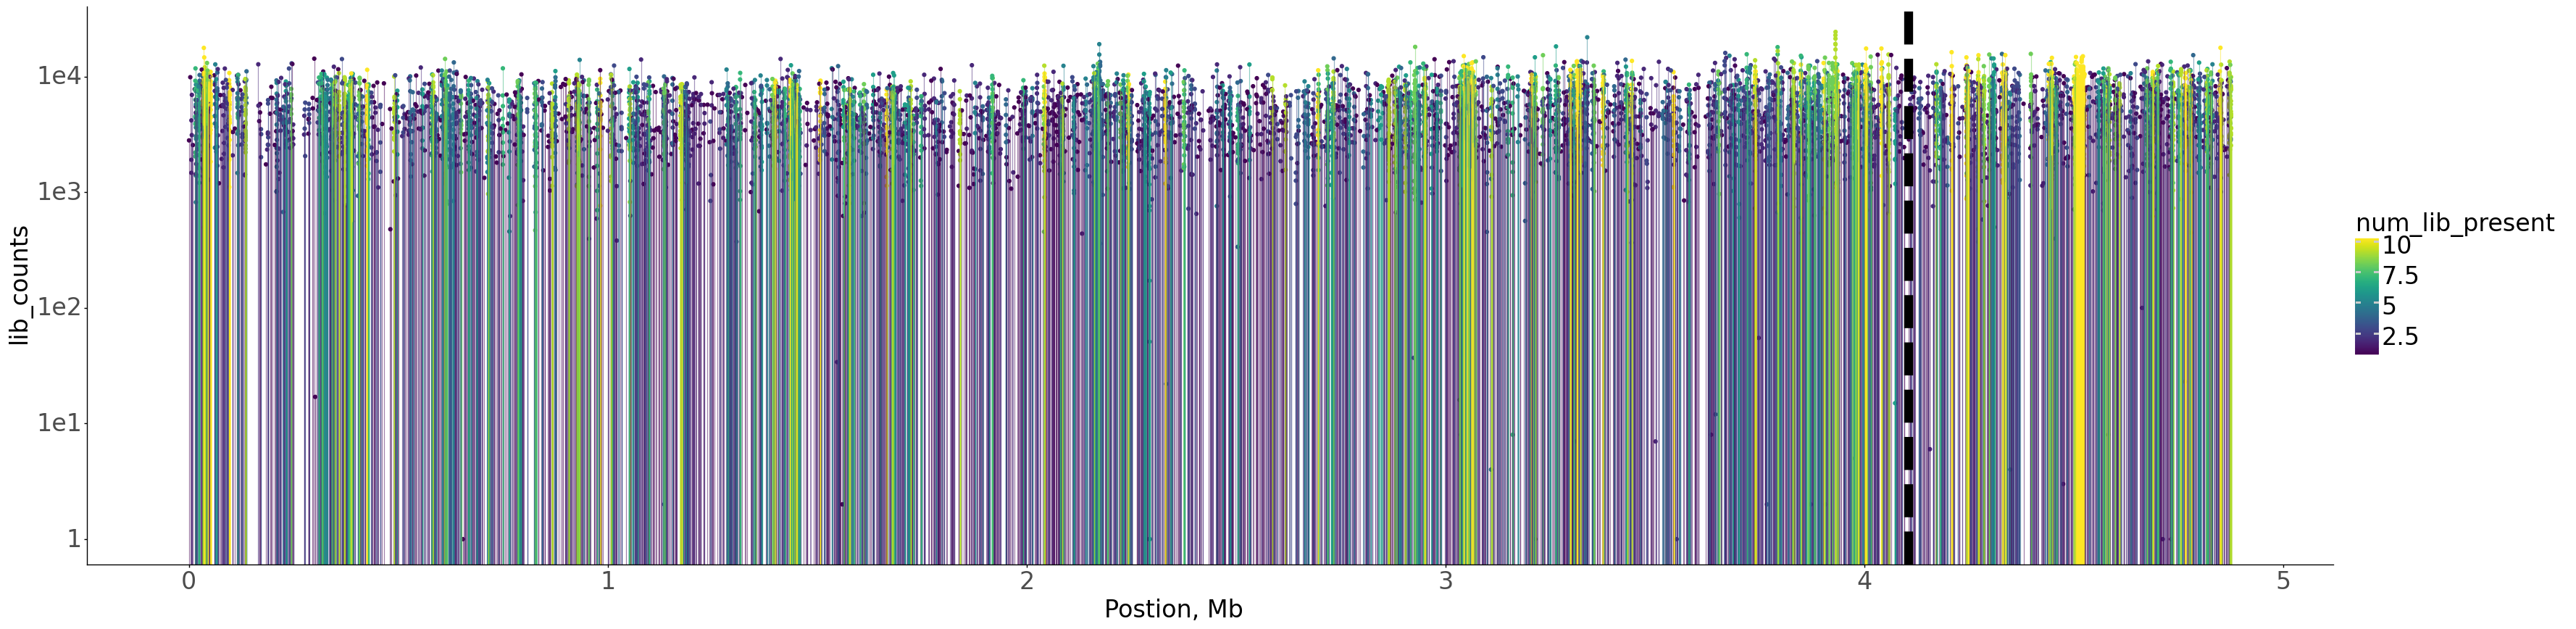

<ggplot: (2992808783484)>

In [198]:
g

In [199]:
lib_hi.head()

barcode  lib_counts  position          chr strand    norm_count  \
0  CGCCCGCCCAGTTATTC       88513       452  NC_017719.1  minus  80260.333333   
1  TAAGGCCCCAATCGTGC       86827      6881  NC_017719.1  minus  78743.250000   
2  GTTGAATTTCGACGCCA       77612      8103  NC_017719.1  minus  70201.083333   
3  ATTGGATTACAGAACAC       68110        98  NC_017719.1  minus  62160.000000   
4  AGAATGCCAACAATATG       34738      7814  NC_017719.1   plus  31117.250000   

                 locus            gene       library  
0  gene-SL1344_RS24690            sul2  library_10_1  
1  gene-SL1344_RS24725  SL1344_RS24725  library_10_1  
2  gene-SL1344_RS24735     aph(3'')-Ib  library_10_1  
3  gene-SL1344_RS24690            sul2  library_10_1  
4  gene-SL1344_RS24730  SL1344_RS24730  library_10_1

In [130]:
ldf[ldf.Feature == 'gene-SL1344_4404'].head()

barcode  Position     Element           Feature     exp  \
190   ACCTAAGACCTGAGTCG  4.736722  FQ312003.1  gene-SL1344_4404  TV4570   
487   CACGATAAAAGGGACAT  4.736888  FQ312003.1  gene-SL1344_4404  TV4570   
860   GACCAATCCGCAGATCC  4.736682  FQ312003.1  gene-SL1344_4404  TV4570   
1333  TGACCCATCCGCTGAAC  4.737227  FQ312003.1  gene-SL1344_4404  TV4570   
1396  TGTGGGCGTGATAACAC  4.737227  FQ312003.1  gene-SL1344_4404  TV4570   

          dnaid  cnts           lib  barcode_uniq  num_lib_present  
190   dnaid2016  1232  library_10_1            22                9  
487   dnaid2016  2344  library_10_1            22                9  
860   dnaid2016  4390  library_10_1            22                9  
1333  dnaid2016  1189  library_10_1            22                9  
1396  dnaid2016  2676  library_10_1            22                9

/nfs/home/ansintsova/miniconda3/envs/datavis/lib/python3.9/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log10


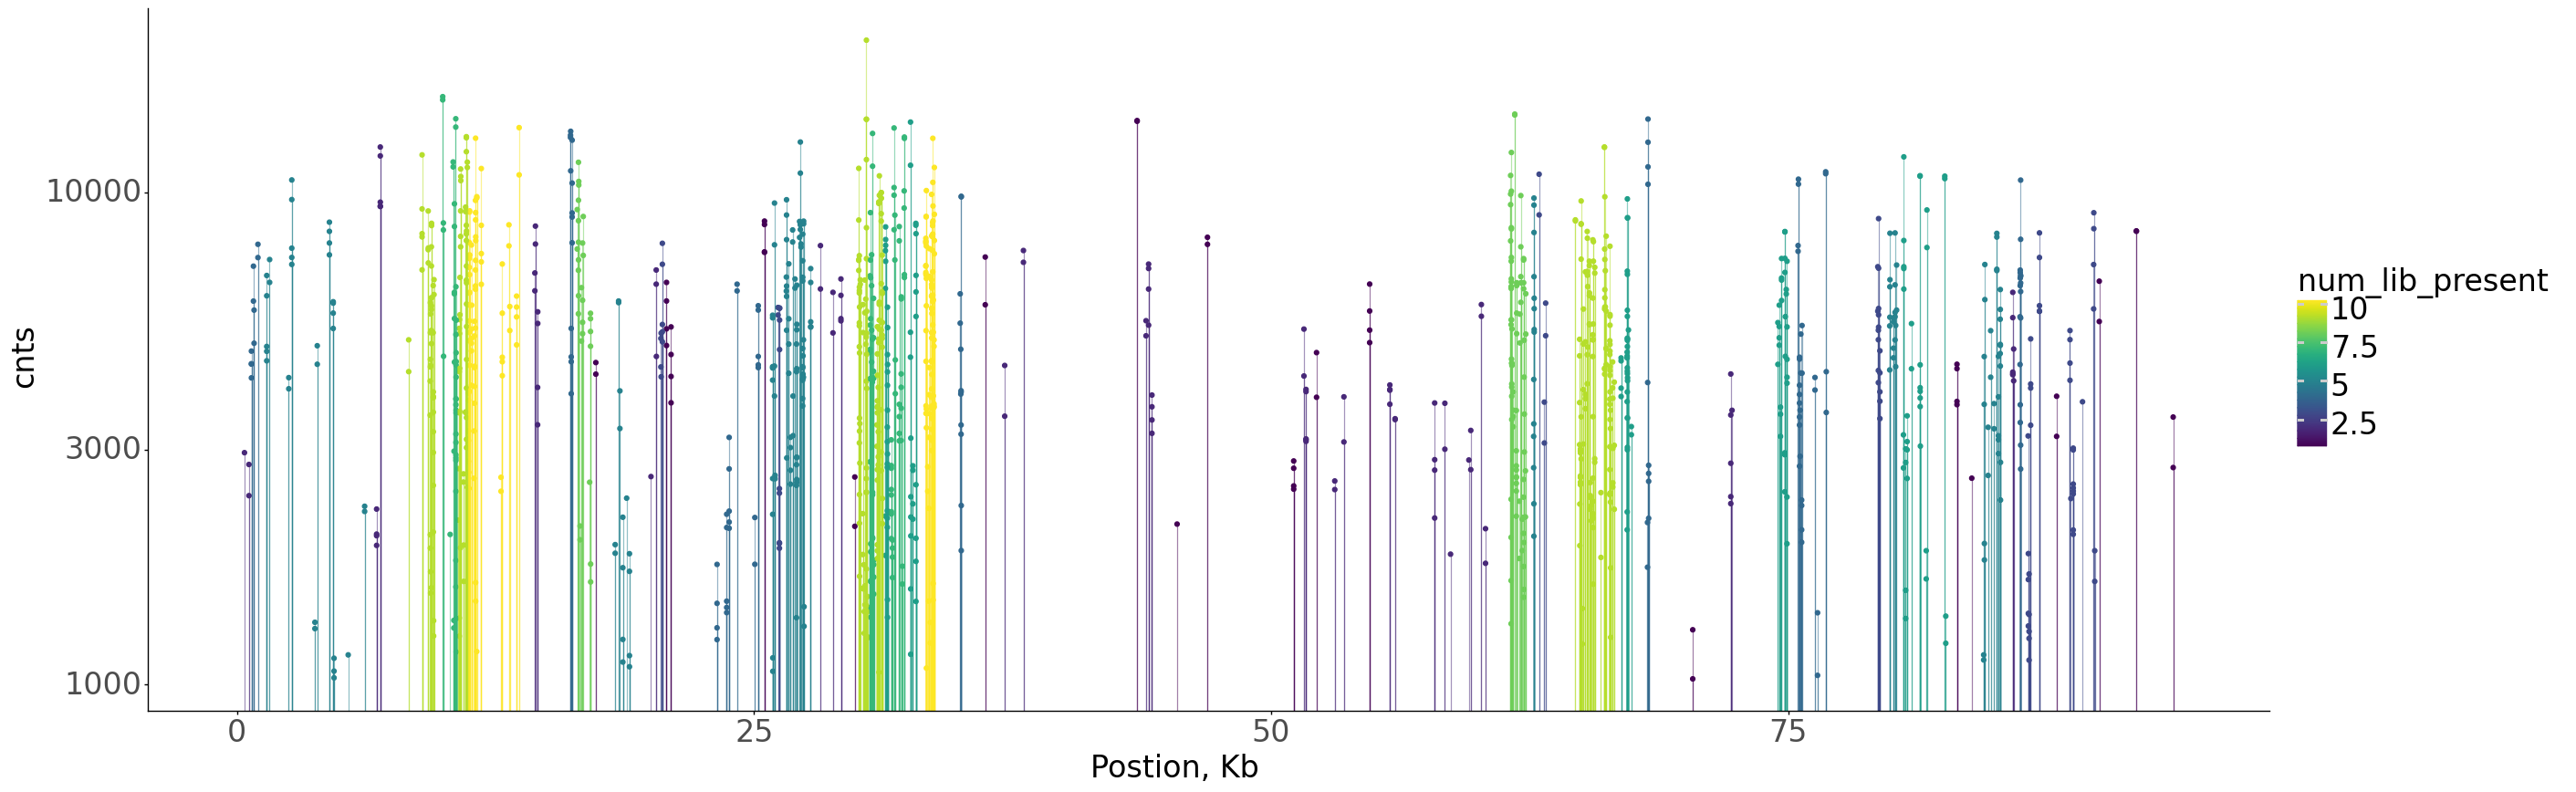

<ggplot: (2992843754894)>

In [82]:

ldf, g = vis_library_insertions(df, element = 'NC_017720.1', div=1000, unit='Kb')
g


/nfs/home/ansintsova/miniconda3/envs/datavis/lib/python3.9/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log10


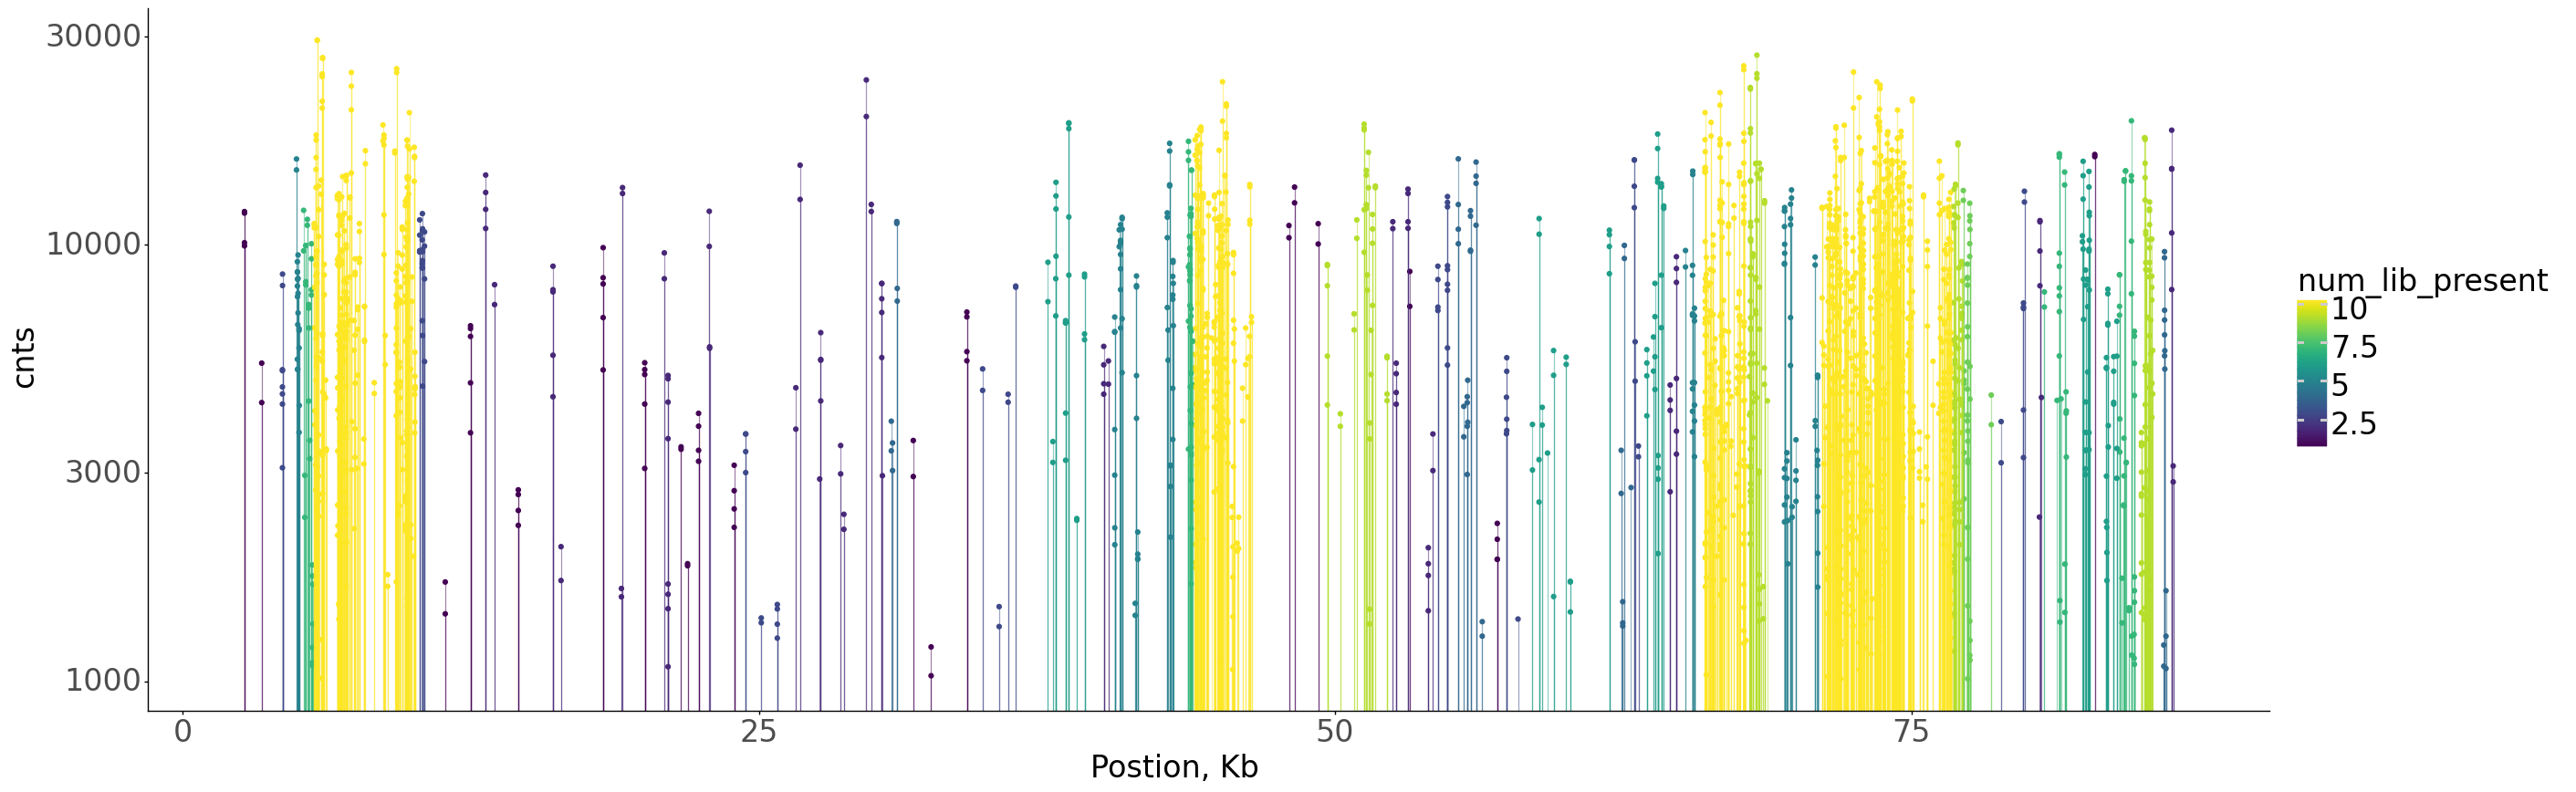

<ggplot: (2992835773142)>

In [83]:
ldf, g = vis_library_insertions(df, element = 'NC_017718.1', div=1000, unit='Kb')
g


/nfs/home/ansintsova/miniconda3/envs/datavis/lib/python3.9/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log10


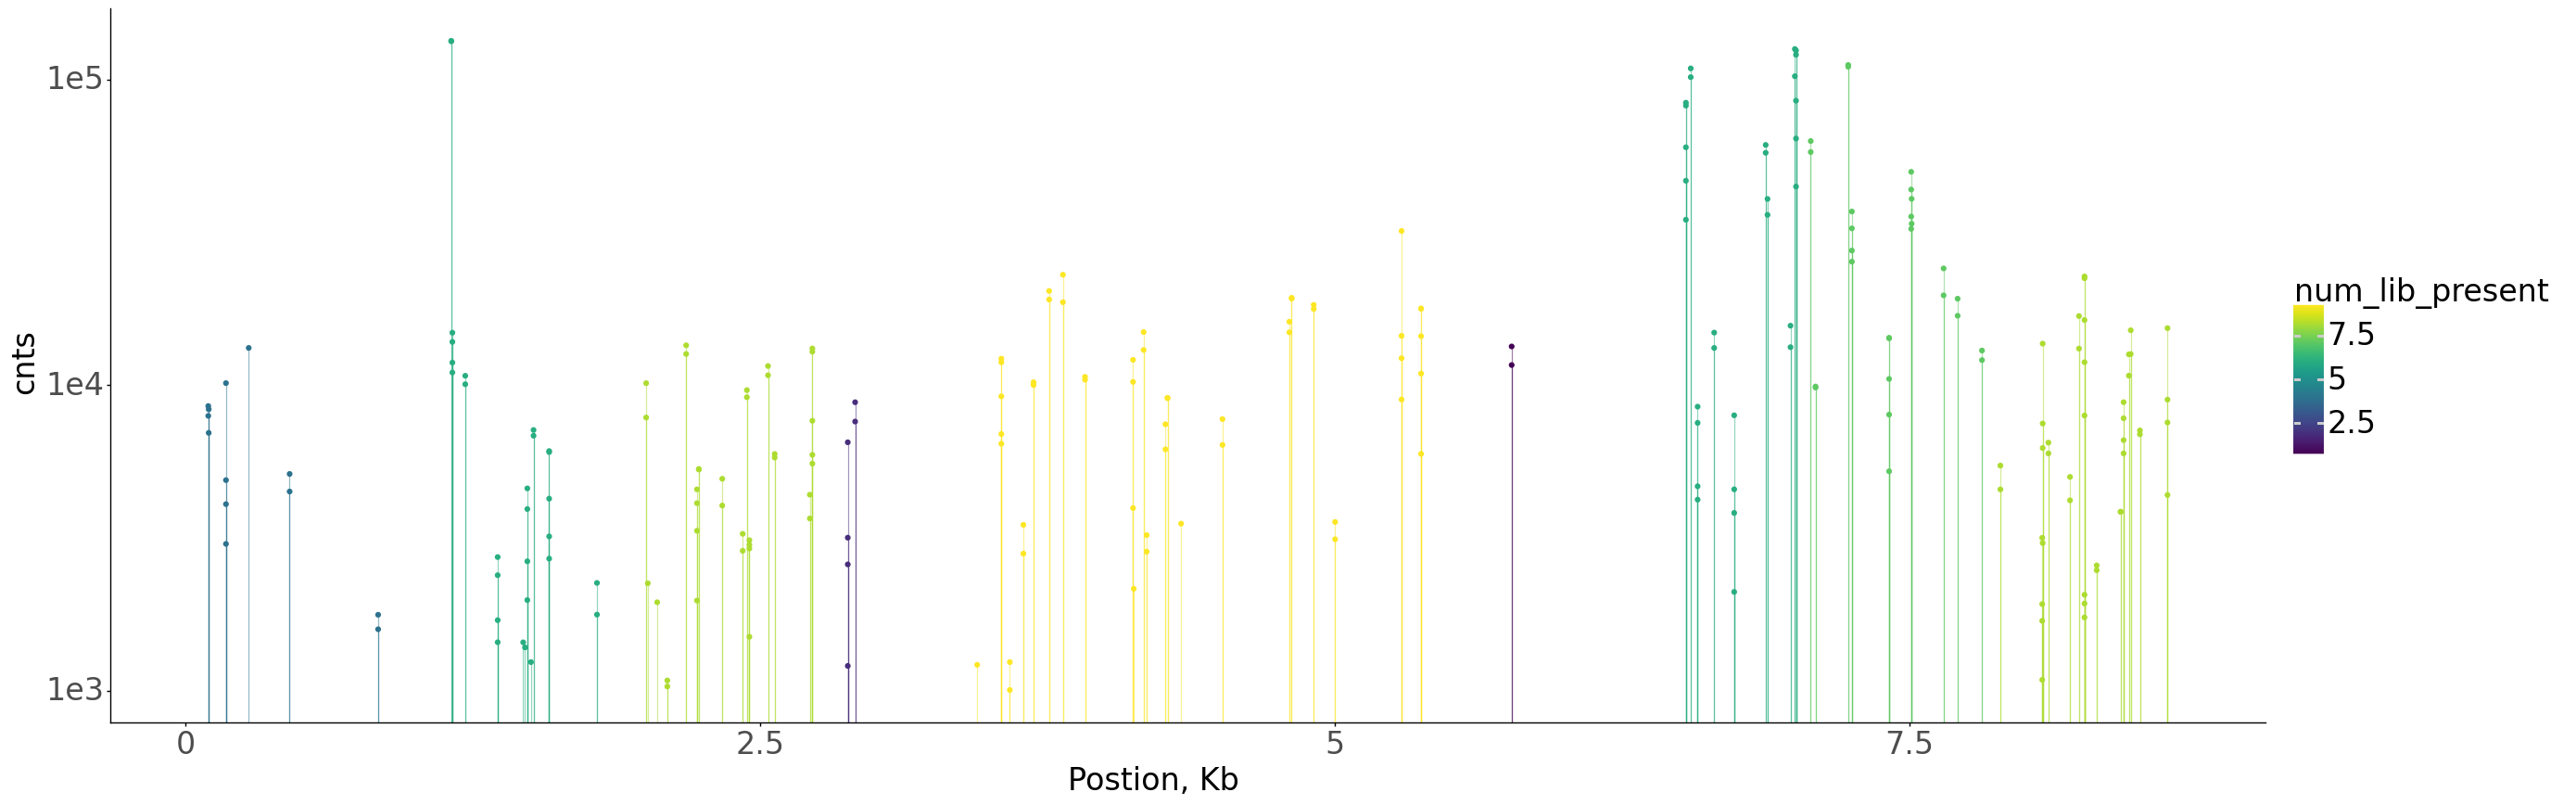

<ggplot: (2992835975153)>

In [84]:
ldf, g = vis_library_insertions(df, element = 'NC_017719.1', div=1000, unit='Kb')
g

In [81]:
df.Element.unique()

array(['FQ312003.1', 'NC_017720.1', nan, 'NC_017718.1', 'NC_017719.1',
       'None'], dtype=object)

/nfs/home/ansintsova/miniconda3/envs/datavis/lib/python3.9/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log10
/nfs/home/ansintsova/miniconda3/envs/datavis/lib/python3.9/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 658 rows containing missing values.
/nfs/home/ansintsova/miniconda3/envs/datavis/lib/python3.9/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_segment : Removed 658 rows containing missing values.


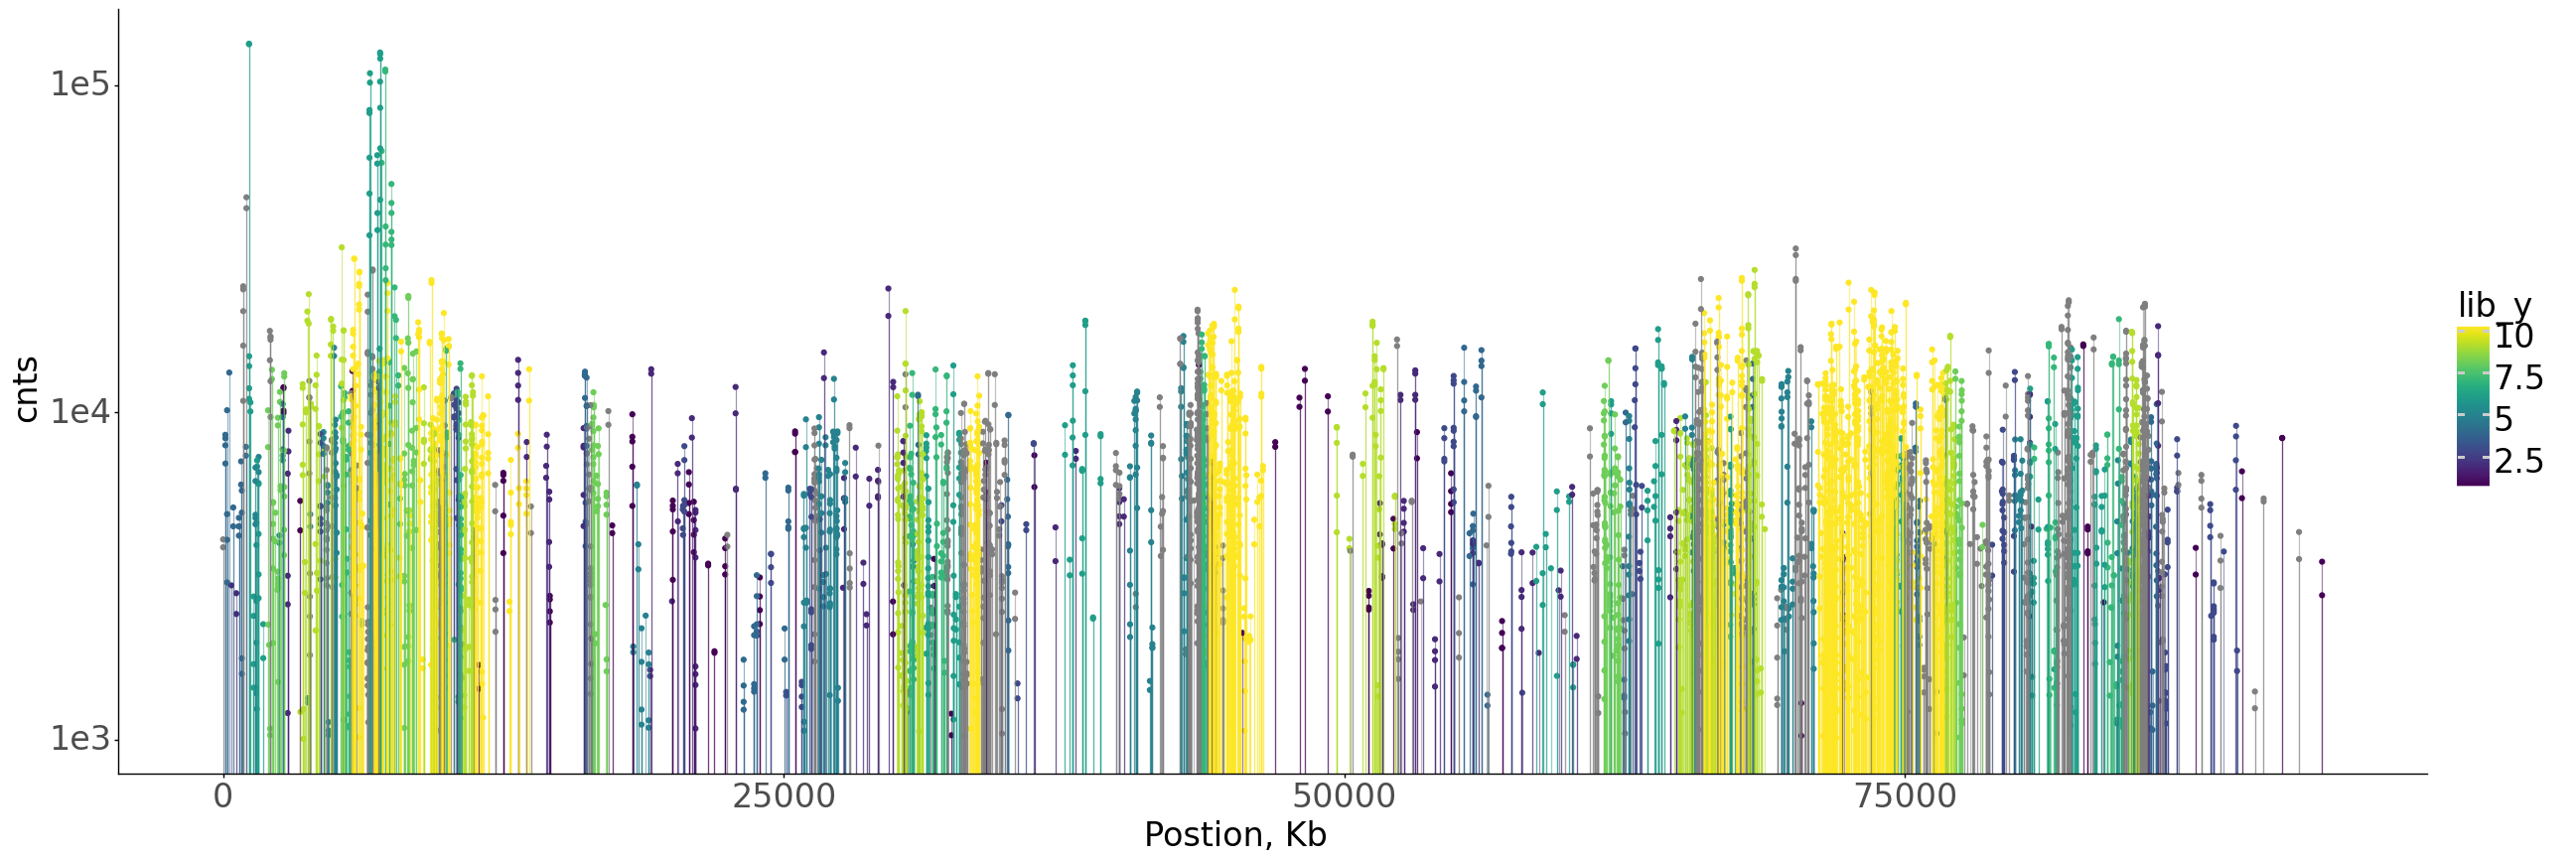

<ggplot: (2992808840677)>

In [52]:
#to_plot3 = lib_sum3.groupby(['Position']).agg({'cnts':'mean', 'barcode':'nunique'}).reset_index()
p9.options.figure_size = (30, 10)
(p9.ggplot(lib_sum3, p9.aes(x='Position', y='cnts', color='lib_y'))
 #+ p9.geom_line()
 + p9.geom_point()
 + p9.geom_segment(p9.aes(x='Position', xend='Position', y='cnts', yend=0), alpha=0.5)
 + p9.theme_classic()
 + p9.theme(text = p9.element_text(size=24))
# + p9.ylab("Count")
  + p9.xlab("Postion, Kb")
  + p9.scale_y_log10())
 #+ p9.scale_color_distiller(palette=1, ))
#  + p9.facet_wrap('~ sample'))

In [26]:
lib_sum2 = df[df['Element'] != 'FQ312003.1']
to_plot2 = lib_sum2.groupby(['Position']).agg({'lib':'nunique', 'cnts':'mean', 'barcode':'nunique'}).reset_index()
to_plot2['Position'] = to_plot2['Position']/1000
to_plot2.shape

(1748, 4)

In [12]:
to_plot.sort_values('barcode').tail()

Position  lib         cnts  barcode
5784   2.293008    3  3274.000000        5
12373  4.520462    3  3872.571429        5
7558   3.051508    6  5709.625000        6
4615   1.722714    3  2581.050000        6
7557   3.051500    9  4458.527778       13

In [19]:
df.groupby('lib').agg({'barcode':'nunique'}).sum()

barcode    17388
dtype: int64

In [21]:
df.head()

barcode   Position      Element           Feature     exp  \
135522  AAAAAACTGATACAAAG  3049115.0   FQ312003.1  gene-SL1344_2861  TV4570   
135525  AAAACAACCGAGACTAA  3763599.0   FQ312003.1  gene-SL1344_3540  TV4570   
135528  AAAACACCGGTGACCAT  3677559.0   FQ312003.1  gene-SL1344_3466  TV4570   
135532  AAAACCACGAACGTTAC  2169771.0   FQ312003.1  gene-SL1344_2067  TV4570   
135537  AAAACGCAGCGCTTGCC    65692.0  NC_017720.1                 -  TV4570   

            dnaid  cnts           lib  
135522  dnaid2016  1777  library_10_1  
135525  dnaid2016  4472  library_10_1  
135528  dnaid2016  2798  library_10_1  
135532  dnaid2016  3260  library_10_1  
135537  dnaid2016  4861  library_10_1

In [13]:
to_plot.shape

(13662, 4)

In [68]:
#TV5490A: library_13_1
counts_file = "/nfs/nas22/fs2202/biol_micro_bioinf_nccr/hardt/nguyenb/tnseq/"\
              "scratch/results/dnaid2023/dnaid2023_counts_TV5490A.txt"

mapping_file = "/nfs/nas22/fs2202/biol_micro_bioinf_nccr/hardt/nguyenb/tnseq/"\
                "scratch/results/dnaid2023/dnaid2023_features_TV5490A.txt"

results_file = "/nfs/nas22/fs2202/biol_micro_bioinf_nccr/hardt/nguyenb/tnseq/"\
                "scratch/results/dnaid2023/dnaid2023_results_TV5490A.txt"

omapping_file = "/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/"\
                "chris/hardt/nguyenb/tnseq_mapping_2031/scratch/library_13_1/barcode_map.txt"

In [83]:
lib_13.head()

barcode  lib_counts  position          chr strand  \
194217  TCGGTACTCCCTGTGAC      119371       100  NC_017719.1  minus   
194218  CCCTTTCAGCTGTGCAC      114820      8453  NC_017719.1   plus   
194219  TCACCCCGCTCAAAATA       55659      2912  NC_017719.1  minus   
194220  GAGCAGATCACCTTGGC       40772      7708  NC_017719.1   plus   
194221  CGAGAAGCAATAAATCT       27995      2334  NC_017719.1   plus   

           norm_count                locus            gene       library  
194217  110811.683333  gene-SL1344_RS24690            sul2  library_13_1  
194218  105928.566667  gene-SL1344_RS24735     aph(3'')-Ib  library_13_1  
194219   51642.000000  gene-SL1344_RS24705  SL1344_RS24705  library_13_1  
194220   37186.416667  gene-SL1344_RS24730  SL1344_RS24730  library_13_1  
194221   25149.350000  gene-SL1344_RS24700  SL1344_RS24700  library_13_1

In [134]:
lib_13 = all_lib[all_lib.library == 'library_13_1']
bc_in_lib = [c for c in lib_13.barcode.values if c in inoc_bc]

In [135]:
len(bc_in_lib)

1506

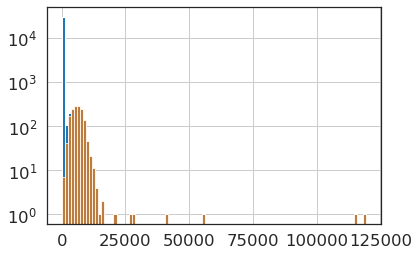

In [137]:
lib_13.lib_counts.hist(bins=100, alpha=1)
lib_13[lib_13.barcode.isin(bc_in_lib)].lib_counts.hist(bins=100, alpha=0.7)
plt.yscale('log')

barcode  lib_counts  position         chr strand  \
561227  GACCAGTGAAATTCACT           1   1611255  FQ312003.1  minus   
572507  NACAATAGCTACTACGA           1   3693957  FQ312003.1   plus   
165036  AAGAGCTGGCAAGCAAT           1    786834  FQ312003.1   plus   
216560  CAGAGATCCCTGCGACT           1    865622  FQ312003.1  minus   
379390  GGAAGCACCCTGAGTTG           1   2293016  FQ312003.1   plus   

        norm_count             locus         gene       library  
561227         1.0  gene-SL1344_1502         yddG   library_9_1  
572507         1.0  gene-SL1344_3480         malQ   library_9_2  
165036         1.0  gene-SL1344_0704  SL1344_0704  library_12_1  
216560         1.0  gene-SL1344_0775         uvrB  library_13_1  
379390         1.0  gene-SL1344_2175  SL1344_2175  library_14_3

In [21]:
all_lib[all_lib.lib_counts > 100].groupby('library').agg({'barcode':['nunique'], 'gene':['nunique'], 'position':['nunique']})

barcode    gene position
             nunique nunique  nunique
library                              
library_10_1    2490    1062     2345
library_10_2    2883    1180     2712
library_10_3    2536    1055     2366
library_11_1    1783     847     1658
library_11_2    2025     899     1915
library_12_1    1836     873     1725
library_12_2    1917     877     1790
library_13_1    1973     911     1869
library_13_2    2587    1056     2404
library_13_3    3765    1342     3504
library_14_1    3799    1349     3539
library_14_2    2200     944     2018
library_14_3    2493    1042     2306
library_15_1    1682     805     1577
library_15_2    2137     933     1986
library_15_3    1984     897     1846
library_16_1    2434    1038     2261
library_16_2    2291    1000     2139
library_9_1     1843     874     1746
library_9_2     1782     840     1707
library_9_3        1       1        1

In [60]:
lib_info = all_lib.groupby('library').agg({'barcode':['nunique'], 'gene':['nunique'], 
                                'position':['nunique'], 'lib_counts': ['mean', 'max', 'min']})

In [64]:
lib_info.columns = ["# uniq barcodes", "# uniq genes", '# unique positions', 'mean counts per barcode', 
                   "max count", "min count"]
lib_info.sort_index()

# uniq barcodes  # uniq genes  # unique positions  \
library                                                           
library_10_1            29059          3199               19030   
library_10_2            30620          3380               20048   
library_10_3            27738          2881               15090   
library_11_1            28004          3186               17979   
library_11_2            29558          3341               19346   
library_12_1            22983          2829               14094   
library_12_2            26255          3137               17578   
library_13_1            31799          3306               19743   
library_13_2            29744          2890               14577   
library_13_3            33566          3241               18526   
library_14_1            34562          3435               19755   
library_14_2            29280          2859               14572   
library_14_3            29098          3061               17825   
library_15_1            30787          3243               18852   
library_15_2            29549          2905               14630   
library_15_3            32616          3212               18789   
library_16_1            35986          3384               20803   
library_16_2            30462          2887               15107   
library_9_1             19664          2782               13183   
library_9_2             20921          3013               14669   
library_9_3             12690          2382               10521   

              mean counts per barcode  max count  min count  
library                                                      
library_10_1               298.470078      88513          1  
library_10_2               364.031581     179237          1  
library_10_3               349.334163      91911          1  
library_11_1               393.734002     288066          1  
library_11_2               442.571216     293167          1  
library_12_1               336.868207      79336          1  
library_12_2               328.732775     213211          1  
library_13_1               315.205227     119371          1  
library_13_2               385.797976     117893          1  
library_13_3               266.677650      75283          1  
library_14_1               304.262745      85714          1  
library_14_2               310.667794      95729          1  
library_14_3               266.080590      99056          1  
library_15_1               335.566765      99286          1  
library_15_2               357.028089     295882          1  
library_15_3               345.339465     311566          1  
library_16_1               322.968015     264028          1  
library_16_2               333.306677     197790          1  
library_9_1                301.375509      35352          1  
library_9_2                313.409636      72151          1  
library_9_3                  2.760441        122          1

Text(0.5, 1.0, 'library_13_1')

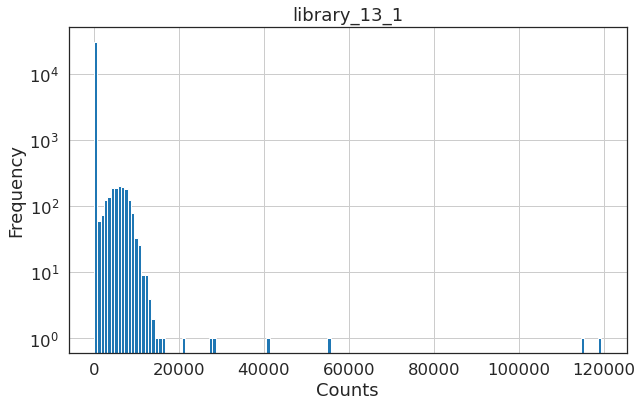

In [66]:
plt.figure(figsize=(10, 6))
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5)
all_lib[all_lib.library == 'library_13_1'].lib_counts.hist(bins=150)
plt.yscale('log')
plt.ylabel("Frequency")
plt.xlabel("Counts")
plt.title("library_13_1")

Text(0.5, 1.0, 'library_9_3')

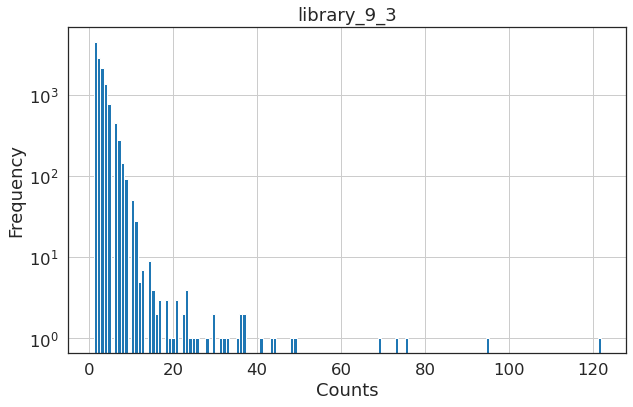

In [67]:
plt.figure(figsize=(10, 6))
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5)

all_lib[all_lib.library == 'library_9_3'].lib_counts.hist(bins=150)
plt.yscale('log')
plt.ylabel("Frequency")
plt.xlabel("Counts")
plt.title("library_9_3")

In [20]:
all_lib[all_lib.chr == 'FQ312003.1'].head()

lib_counts  position         chr strand    norm_count  \
ATAGATGTAGTACCAGA       11274    595415  FQ312003.1  minus  10097.000000   
AGCTAGACGGAAGGACT       10851    134013  FQ312003.1  minus  10020.866667   
CCTGGCCAGGAATGCGG       10502   4463158  FQ312003.1  minus   9171.719048   
CCCCAGACAGCTGCTCT        9898   3051500  FQ312003.1   plus   9289.500000   
GCATAGAACAGAACTGG        9879   4304173  FQ312003.1   plus   8616.000000   

                              locus  gene       library  
ATAGATGTAGTACCAGA  gene-SL1344_0525  arcC  library_10_1  
AGCTAGACGGAAGGACT                 -     -  library_10_1  
CCTGGCCAGGAATGCGG                 -     -  library_10_1  
CCCCAGACAGCTGCTCT  gene-SL1344_2863  sipC  library_10_1  
GCATAGAACAGAACTGG  gene-SL1344_4022  ydeW  library_10_1

In [146]:
all_lib[all_lib.barcode == 'AGCTAGACGGAAGGACT']

barcode  lib_counts  position         chr strand  \
12      AGCTAGACGGAAGGACT       10851    134013  FQ312003.1  minus   
31505   AGCTAGACGGAAGGACT         187    134013  FQ312003.1  minus   
62889   AGCTAGACGGAAGGACT          13    134013  FQ312003.1  minus   
94837   AGCTAGACGGAAGGACT           5    134013  FQ312003.1  minus   
171208  AGCTAGACGGAAGGACT          10    134013  FQ312003.1  minus   
261137  AGCTAGACGGAAGGACT          16    134013  FQ312003.1  minus   
359224  AGCTAGACGGAAGGACT           6    134013  FQ312003.1  minus   
447754  AGCTAGACGGAAGGACT           7    134013  FQ312003.1  minus   
544904  AGCTAGACGGAAGGACT           5    134013  FQ312003.1  minus   

          norm_count locus gene       library  
12      10020.866667     -    -  library_10_1  
31505     185.000000     -    -  library_10_2  
62889      11.000000     -    -  library_10_3  
94837       4.000000     -    -  library_11_1  
171208      9.000000     -    -  library_12_2  
261137     15.000000     -    -  library_13_3  
359224      5.000000     -    -  library_14_3  
447754      7.000000     -    -  library_15_3  
544904      5.000000     -    -   library_9_1

In [210]:
all_lib[all_lib.barcode == 'ATGGCCAGCCAATCTAG']

barcode  lib_counts  position         chr strand  \
36149   ATGGCCAGCCAATCTAG           7   3041013  FQ312003.1   plus   
126467  ATGGCCAGCCAATCTAG           4   3041013  FQ312003.1   plus   
201855  ATGGCCAGCCAATCTAG           6   3041013  FQ312003.1   plus   
295970  ATGGCCAGCCAATCTAG          10   3041013  FQ312003.1   plus   
363691  ATGGCCAGCCAATCTAG           3   3041013  FQ312003.1   plus   
382804  ATGGCCAGCCAATCTAG        7249   3041013  FQ312003.1   plus   
418905  ATGGCCAGCCAATCTAG           5   3041013  FQ312003.1   plus   
486802  ATGGCCAGCCAATCTAG           4   3041013  FQ312003.1   plus   
568029  ATGGCCAGCCAATCTAG           3   3041013  FQ312003.1   plus   

        norm_count             locus  gene       library  
36149          7.0  gene-SL1344_2855  hilD  library_10_2  
126467         4.0  gene-SL1344_2855  hilD  library_11_2  
201855         5.0  gene-SL1344_2855  hilD  library_13_1  
295970        10.0  gene-SL1344_2855  hilD  library_14_1  
363691         2.0  gene-SL1344_2855  hilD  library_14_3  
382804      6836.0  gene-SL1344_2855  hilD  library_15_1  
418905         5.0  gene-SL1344_2855  hilD  library_15_2  
486802         4.0  gene-SL1344_2855  hilD  library_16_1  
568029         3.0  gene-SL1344_2855  hilD   library_9_2

In [212]:
df[df.barcode == 'ATGGCCAGCCAATCTAG']

barcode   Position     Element           Feature      exp  \
3338   ATGGCCAGCCAATCTAG  3041013.0  FQ312003.1  gene-SL1344_2855  TV5536C   
2127   ATGGCCAGCCAATCTAG        NaN         NaN               NaN  TV5536A   
12020  ATGGCCAGCCAATCTAG  3041013.0  FQ312003.1  gene-SL1344_2855  TV5536C   

           dnaid   cnts           lib  
3338   dnaid2026  11306  library_15_1  
2127   dnaid2026   1110   library_9_1  
12020  dnaid2025  10616  library_15_1

In [173]:
all_lib[all_lib.barcode == 'ACGGTGAGGAGAGGGAG'][['barcode', 'lib_counts', 'position', 'chr', 'gene', 'library']]

barcode  lib_counts  position         chr         gene  \
17000   ACGGTGAGGAGAGGGAG           2   4755606  FQ312003.1  SL1344_4418   
38143   ACGGTGAGGAGAGGGAG           5   4755606  FQ312003.1  SL1344_4418   
65927   ACGGTGAGGAGAGGGAG           6   4755606  FQ312003.1  SL1344_4418   
97067   ACGGTGAGGAGAGGGAG           4   4755606  FQ312003.1  SL1344_4418   
119749  ACGGTGAGGAGAGGGAG          10   4755606  FQ312003.1  SL1344_4418   
149327  ACGGTGAGGAGAGGGAG           8   4755606  FQ312003.1  SL1344_4418   
173563  ACGGTGAGGAGAGGGAG           6   4755606  FQ312003.1  SL1344_4418   
198365  ACGGTGAGGAGAGGGAG          11   4755606  FQ312003.1  SL1344_4418   
226104  ACGGTGAGGAGAGGGAG       11602   4755606  FQ312003.1  SL1344_4418   
256053  ACGGTGAGGAGAGGGAG        3756   4755606  FQ312003.1  SL1344_4418   
289557  ACGGTGAGGAGAGGGAG        4696   4755606  FQ312003.1  SL1344_4418   
326816  ACGGTGAGGAGAGGGAG          18   4755606  FQ312003.1  SL1344_4418   
359219  ACGGTGAGGAGAGGGAG           6   4755606  FQ312003.1  SL1344_4418   
389744  ACGGTGAGGAGAGGGAG           5   4755606  FQ312003.1  SL1344_4418   
415571  ACGGTGAGGAGAGGGAG          15   4755606  FQ312003.1  SL1344_4418   
449745  ACGGTGAGGAGAGGGAG           5   4755606  FQ312003.1  SL1344_4418   
480424  ACGGTGAGGAGAGGGAG           9   4755606  FQ312003.1  SL1344_4418   
516340  ACGGTGAGGAGAGGGAG           8   4755606  FQ312003.1  SL1344_4418   
550873  ACGGTGAGGAGAGGGAG           2   4755606  FQ312003.1  SL1344_4418   
568758  ACGGTGAGGAGAGGGAG           3   4755606  FQ312003.1  SL1344_4418   
590272  ACGGTGAGGAGAGGGAG           2   4755606  FQ312003.1  SL1344_4418   

             library  
17000   library_10_1  
38143   library_10_2  
65927   library_10_3  
97067   library_11_1  
119749  library_11_2  
149327  library_12_1  
173563  library_12_2  
198365  library_13_1  
226104  library_13_2  
256053  library_13_3  
289557  library_14_1  
326816  library_14_2  
359219  library_14_3  
389744  library_15_1  
415571  library_15_2  
449745  library_15_3  
480424  library_16_1  
516340  library_16_2  
550873   library_9_1  
568758   library_9_2  
590272   library_9_3

barcode  lib_counts  position         chr strand  norm_count  \
10397  ATGGCCAGCCAATCTAG        7249  3.041013  FQ312003.1   plus      6836.0   

                  locus  gene       library  barcode_uniq  num_lib_present  
10397  gene-SL1344_2855  hilD  library_15_1            14                8

In [202]:
t = lib_hi.groupby(['barcode', 'chr', 'position']).agg({'library':['count']}).reset_index()
t.columns = ['Barcode', 'Chromosome', 'Positon', 'num_lib']
t.sort_values('num_lib').tail(25)

Barcode   Chromosome  Positon  num_lib
5701   CACCCCGAATCCGCCTA   FQ312003.1  2265797        1
5702   CACCCCGCACCTTGAGC   FQ312003.1  1186244        1
5703   CACCCCGGGCGGAGCTG  NC_017718.1    45109        1
5720   CACCCTACAATTGATTA   FQ312003.1  2163903        1
5705   CACCCCGTTCCGTGTCC   FQ312003.1  1185242        1
5704   CACCCCGTACCAGGATC   FQ312003.1    95160        1
5706   CACCCCTAGAAGAGGGT   FQ312003.1  1126208        1
5718   CACCCGTCAGAAAGTCG   FQ312003.1  3207803        1
5717   CACCCGGTATGGCCTAG   FQ312003.1   489937        1
5716   CACCCGGGATACTTTAT   FQ312003.1  1680857        1
5715   CACCCGGGAGGAATACC   FQ312003.1  4503219        1
5714   CACCCGCTTCTAATGAA  NC_017720.1    44074        1
5713   CACCCGCTCACTGAATC   FQ312003.1  1060797        1
5712   CACCCGCTACGAATCGG   FQ312003.1  4559172        1
17127  TTTTTTTAAAAGTTCAC   FQ312003.1  1422957        1
5711   CACCCGCGCACGACCGG  NC_017720.1    52551        1
5710   CACCCGCCAGCTAGCAG   FQ312003.1  1315517        1
5709   CACCCGAGCAGAACCAT   FQ312003.1  3043231        1
5708   CACCCGACCGTGGCCAG   FQ312003.1  4002356        1
5707   CACCCCTTTTGAGAACG   FQ312003.1  3738093        1
1586   ACAAATGATAGTGCGGG   FQ312003.1  3040674        2
8153   CGCCCCGGTAAGGCCGA  NC_017718.1    64807        2
10828  GCAAGAAAGGCACACTA   FQ312003.1  3040995        2
43     AAAACACCAAAACCAAG   FQ312003.1  1399870        2
5543   CAATTAACCCCCTACGG   FQ312003.1  3041015        3

In [147]:
chr_df = all_lib[all_lib.chr == 'FQ312003.1']

In [201]:
t = all_lib.groupby(['barcode', 'chr', 'position']).agg({'library':['count']}).reset_index()
t.columns = ['Barcode', 'Chromosome', 'Positon', 'num_lib']
t.sort_values('num_lib').tail(25)

Barcode   Chromosome  Positon  num_lib
225509  GGGCCAGCGACCTAATG   FQ312003.1  3305951       17
306578  TTGCCAGATCAAACGGC   FQ312003.1     2321       17
51565   ACGCTAAACAGCTAGAC   FQ312003.1  4208188       17
52615   ACGGGCCAGAAAATATC   FQ312003.1  3848855       17
86941   ATCAAACGACGCCTAAA   FQ312003.1  4503274       17
110911  CACTGGACCGAAGCACT  NC_017718.1      421       17
97674   ATTTCGCCCCTCAGTGG   FQ312003.1   364882       17
115882  CAGTTATATAGGTTGAC   FQ312003.1  4181800       17
219406  GGCAGCCAGCAGTATGG   FQ312003.1  4426342       17
152394  CGGACGTGTGGCACTAT   FQ312003.1  3648028       17
22982   AAGCCGAACATCCCGAC  NC_017719.1     4776       17
79488   AGTTTAATCCCATCGTC   FQ312003.1  4830050       17
204401  GCCTGGGATCACCATTG   FQ312003.1  3831167       17
47463   ACCTCCATGCCGCTCGG  NC_017718.1    77331       17
184789  GACTTATGAGACAGCAT  NC_017719.1      444       17
270970  TCAACGCACGCGCTTAG   FQ312003.1   386654       17
64759   AGATATCTCACGATTTG  NC_017718.1     6139       17
94349   ATGTCCTGAAAATCAAT   FQ312003.1    88024       17
246664  GTTCACTAATGCAAGAC  NC_017719.1     3851       17
161896  CTACCCCAGTGCTCCGC  NC_017718.1    76953       17
298369  TGTTGCGAGTATTCAAC   FQ312003.1   666432       17
171487  CTTGAGCCTGCAATAGA  NC_017720.1     7945       18
182326  GACCTGATTCAGGCCGT  NC_017719.1     4811       18
113514  CAGCGGAAAACTGCGCG   FQ312003.1  3501493       19
52994   ACGGTGAGGAGAGGGAG   FQ312003.1  4755606       21

Text(0, 0.5, '# of barcodes')

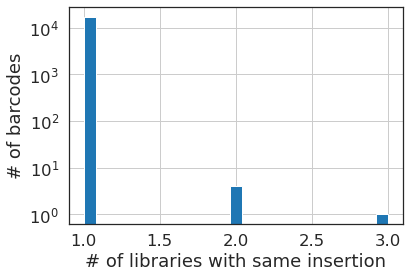

In [207]:
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5)
t.num_lib.hist(bins=25)
plt.yscale("log")
plt.xlabel('# of libraries with same insertion')
plt.ylabel("# of barcodes")
#plt.xlim(1, 22)

Text(0, 0.5, '# of barcodes')

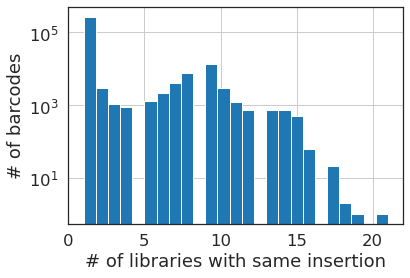

In [168]:
t.num_lib.hist(bins=25)
plt.yscale("log")
plt.xlabel('# of libraries with same insertion')
plt.ylabel("# of barcodes")

In [164]:
t.barcode.nunique()

292969

In [176]:
t[t.num_lib == 1].shape[0]/t.shape[0]

0.8690287201053618

In [ ]:
all_lib.reset_index().rename({'index':'barcode'}, axis=1).groupby('library').barcode.nunique()

In [248]:
chrom = t[t.chr == 'FQ312003.1']
chrom.head()

counts  position         chr strand    norm_count  \
CCACCATCCTCGTAAAG   21323   3930420  FQ312003.1  minus  19036.116667   
CGTGGCTCAGATTCGGG   16037   3667387  FQ312003.1  minus  15051.333333   
CGCCGGATTTGACTTGA   15715   4327942  FQ312003.1   plus  13374.000000   
ATGTTAATAAGAAAAAC   14545   4447102  FQ312003.1  minus  13262.750000   
GTTATGATGGATAGACG   14025   3429304  FQ312003.1   plus  12967.333333   

                              locus         gene       library  
CCACCATCCTCGTAAAG  gene-SL1344_3679         rfaL  library_13_1  
CGTGGCTCAGATTCGGG  gene-SL1344_3459         comA  library_13_1  
CGCCGGATTTGACTTGA  gene-SL1344_4046  SL1344_4046  library_13_1  
ATGTTAATAAGAAAAAC  gene-SL1344_4139  SL1344_4139  library_13_1  
GTTATGATGGATAGACG  gene-SL1344_3213         tdcE  library_13_1

In [281]:
test = chrom.sort_values(by='position')[chrom.counts > 1000]
test['position'] = test['position']/1000000
test

<ipython-input-281-91f390cfe264>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


counts  position         chr strand   norm_count  \
ATGCGCTCATGACTCAA    7880  0.015868  FQ312003.1   plus  7443.500000   
CTACGCTCGTGTCCGCG    5755  0.016501  FQ312003.1   plus  5295.166667   
CTTATTGGGTGGTAAAG    8533  0.016695  FQ312003.1   plus  7857.000000   
GTGCTCCTAATGCGCGC   10338  0.025346  FQ312003.1  minus  9433.476190   
GTCGAGGAAGTTAATGC    4848  0.033625  FQ312003.1  minus  4129.000000   
...                   ...       ...         ...    ...          ...   
TCGCGGGAATACAACTT    3867  4.851309  FQ312003.1   plus  3758.000000   
AGACTCTAGGCCTCCTC    7230  4.859552  FQ312003.1  minus  6490.000000   
TTACCTATCACAGCTGT    4763  4.869937  FQ312003.1  minus  4237.083333   
GGTGATCACTAAACTTT    5834  4.873052  FQ312003.1  minus  5655.500000   
TGAATGCCTAAGGACAG    9460  4.873059  FQ312003.1  minus  8815.983333   

                              locus         gene       library  
ATGCGCTCATGACTCAA  gene-SL1344_0014  SL1344_0014  library_13_1  
CTACGCTCGTGTCCGCG  gene-SL1344_0016  SL1344_0016  library_13_1  
CTTATTGGGTGGTAAAG  gene-SL1344_0016  SL1344_0016  library_13_1  
GTGCTCCTAATGCGCGC  gene-SL1344_0022         bcfB  library_13_1  
GTCGAGGAAGTTAATGC  gene-SL1344_0031  SL1344_0031  library_13_1  
...                             ...          ...           ...  
TCGCGGGAATACAACTT  gene-SL1344_4502  SL1344_4502  library_13_1  
AGACTCTAGGCCTCCTC                 -            -  library_13_1  
TTACCTATCACAGCTGT  gene-SL1344_4519         sthD  library_13_1  
GGTGATCACTAAACTTT  gene-SL1344_4521         sthA  library_13_1  
TGAATGCCTAAGGACAG  gene-SL1344_4521         sthA  library_13_1  

[1420 rows x 8 columns]

In [295]:
all_lib[all_lib.position == 4877761]

counts  position         chr strand  norm_count  \
AAGCTTAGCACCAAGTG       8   4877761  FQ312003.1  minus         5.0   
AAGCTTAGCACCAAGTG       9   4877761  FQ312003.1  minus         7.0   
AAGCTTAGCACCAAGTG    4984   4877761  FQ312003.1  minus      3979.5   
GAGCTCAGCACCAAGTG       1   4877761  FQ312003.1  minus         1.0   
AAGCTTAACACCAAGAG       1   4877761  FQ312003.1  minus         1.0   
AAGCTTAGCACCAAGTG       3   4877761  FQ312003.1  minus         3.0   
AAGCTTAGCACCAAGTG       7   4877761  FQ312003.1  minus         6.0   
AAGCTTAGCACCAAGTG       5   4877761  FQ312003.1  minus         4.0   
AAGCTTAGCACCAAGTG       5   4877761  FQ312003.1  minus         3.0   
AAGCTTAGCACCAAGTG       2   4877761  FQ312003.1  minus         1.0   

                              locus  gene       library  
AAGCTTAGCACCAAGTG  gene-SL1344_4527  lasT  library_10_1  
AAGCTTAGCACCAAGTG  gene-SL1344_4527  lasT  library_10_2  
AAGCTTAGCACCAAGTG  gene-SL1344_4527  lasT  library_10_3  
GAGCTCAGCACCAAGTG  gene-SL1344_4527  lasT  library_10_3  
AAGCTTAACACCAAGAG  gene-SL1344_4527  lasT  library_10_3  
AAGCTTAGCACCAAGTG  gene-SL1344_4527  lasT  library_12_1  
AAGCTTAGCACCAAGTG  gene-SL1344_4527  lasT  library_13_2  
AAGCTTAGCACCAAGTG  gene-SL1344_4527  lasT  library_14_2  
AAGCTTAGCACCAAGTG  gene-SL1344_4527  lasT  library_15_2  
AAGCTTAGCACCAAGTG  gene-SL1344_4527  lasT  library_16_2

In [315]:
all_lib_chr = all_lib[all_lib['chr'] == 'FQ312003.1']
to_plot = all_lib_chr.groupby('position').agg({'library':'nunique', 'counts':'mean'}).reset_index()
to_plot['position'] = to_plot['position']/1000000
to_plot.head()

position  library      counts
0  0.000047        1    1.000000
1  0.000124        1    1.000000
2  0.000133       10  362.583333
3  0.000134        1    1.000000
4  0.000135        1    1.000000

/nfs/home/ansintsova/miniconda3/envs/datavis/lib/python3.9/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log10


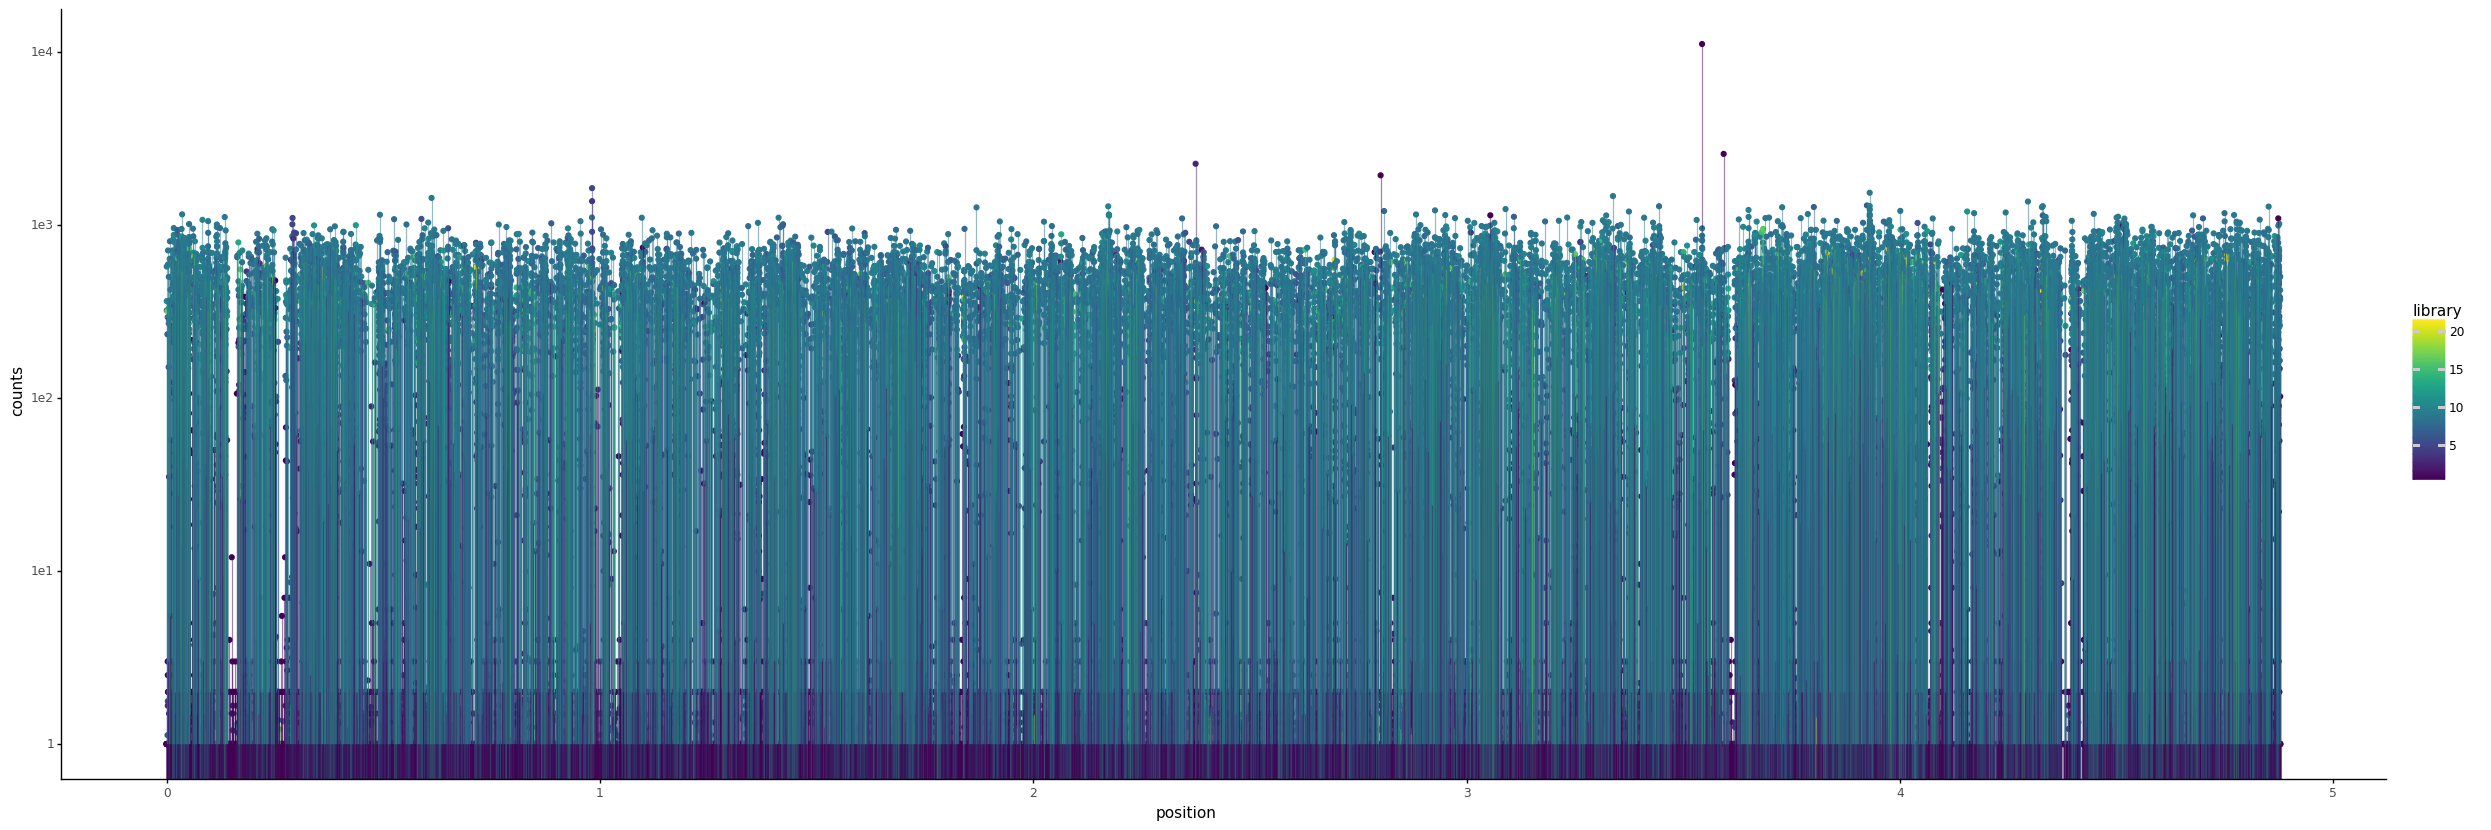

<ggplot: (2955670299058)>

In [337]:
p9.options.figure_size = (30, 10)
(p9.ggplot(to_plot, p9.aes(x='position', y='counts', color='library'))
 #+ p9.geom_line()
 + p9.geom_point()
 + p9.geom_segment(p9.aes(x='position', xend='position', y='counts', yend=0), alpha=0.5)
 + p9.theme_classic()
#  + p9.ylab("Count")
#  + p9.xlab("Conc")
  + p9.scale_y_log10())
 #+ p9.scale_color_distiller(palette=1, ))
#  + p9.facet_wrap('~ sample'))

(0.0, 100.0)

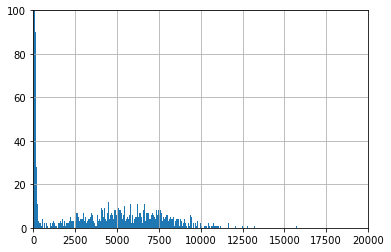

In [59]:
t = library_qc(omapping_file)
t.counts.hist(bins=5000)
plt.xlim(0, 20000)
plt.ylim(0, 100)

In [244]:
#chromosome
chrom = t[t.chr == 'FQ312003.1']
chrom = chrom.rename({'counts': 'read_num'}, axis=1)

bc_per_position = (chrom.groupby('position').read_num.count()>1)
pos_keep = bc_per_position[bc_per_position].index
fnc = lambda x: x.value_counts().sort_index().head(2)
chrom2 = chrom[chrom.position.isin(pos_keep)]
grp = chrom2.groupby('position')['read_num'].apply(fnc)#.reset_index(1, name='cnts')
# Get positions wiht more than one barcode mapped
#
##pos_with_multiple_bc = bc_per_position.where(bc_per_position > 1).dropna()
#position = pos_with_multiple_bc.index
# Subset to these positions, group by position 

In [245]:
grp.reset_index()

position  level_1  read_num
0         8640        2         1
1         8640        6         1
2        15460        1         1
3        15460        4         1
4        15868        1         6
...        ...      ...       ...
5913   4873404        5         1
5914   4873414       12         1
5915   4873414       41         1
5916   4874976        1         1
5917   4874976        8         1

[5918 rows x 3 columns]

In [233]:
grp

position      
801       1       1
          11      1
832       1       2
          8089    1
867       1       1
                 ..
85893     5175    1
86592     1       1
          9       1
88773     2       1
          7       1
Name: read_num, Length: 363, dtype: int64

In [234]:
x

position  level_1  read_num
0         801        1         1
1         832        1         2
2         867        1         1
3        2997        1         1
4        3114        1         1
..        ...      ...       ...
181     85645        1         8
182     85653        1         1
183     85893        1         3
184     86592        1         1
185     88773        2         1

[186 rows x 3 columns]

In [235]:
chrom[chrom.position == 832]

read_num  position          chr strand  norm_count  \
TGAACATAACCACGGGC      8089       832  NC_017720.1  minus     7486.75   
GGAACACAACCACGGGC         1       832  NC_017720.1  minus        1.00   
TGANCACAACCACGGGC         1       832  NC_017720.1  minus        1.00   

                                 locus  gene       library  
TGAACATAACCACGGGC  gene-SL1344_RS23645  traX  library_13_1  
GGAACACAACCACGGGC  gene-SL1344_RS23645  traX  library_13_1  
TGANCACAACCACGGGC  gene-SL1344_RS23645  traX  library_13_1

In [74]:
t2 = t.groupby(['chr', 'position']).agg({'counts':['count', 'mean']}).reset_index()

In [93]:
t2[t2[('counts', 'count')] >1]

chr position counts             
                             count         mean
14      FQ312003.1     8640      2     4.000000
27      FQ312003.1    15460      2     2.500000
33      FQ312003.1    15868      9   885.444444
46      FQ312003.1    16498      5     4.200000
49      FQ312003.1    16695      9   949.000000
...            ...      ...    ...          ...
19727  NC_017720.1    85653      2     7.000000
19730  NC_017720.1    85893      4  1294.500000
19743  NC_017720.1    86592      2     5.000000
19755  NC_017720.1    88773      2     4.500000
19770         None       -1    360     1.000000

[3570 rows x 4 columns]

In [92]:
t[t.position == 4816912]['counts'].nlargest(2)[1]

2

array([[<AxesSubplot:title={'center':"('counts', 'count')"}>]],
      dtype=object)

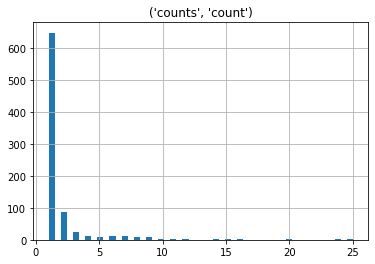

In [79]:
t2[t2.chr == 'NC_017720.1'][[('counts', 'count')]].hist(bins=50)

In [60]:
t[t.counts > 2].shape

(14922, 8)

In [ ]:
## old_map = pd.read_table(omapping_file, header=None)
old_map[6].value_counts().loc['gene-SL1344_RS24690']

In [34]:
old_map.head()

0       1     2            3      4              5  \
0  TCGGTACTCCCTGTGAC  119371   100  NC_017719.1  minus  110811.683333   
1  CCCTTTCAGCTGTGCAC  114820  8453  NC_017719.1   plus  105928.566667   
2  TCACCCCGCTCAAAATA   55659  2912  NC_017719.1  minus   51642.000000   
3  GAGCAGATCACCTTGGC   40772  7708  NC_017719.1   plus   37186.416667   
4  CGAGAAGCAATAAATCT   27995  2334  NC_017719.1   plus   25149.350000   

                     6               7  
0  gene-SL1344_RS24690            sul2  
1  gene-SL1344_RS24735     aph(3'')-Ib  
2  gene-SL1344_RS24705  SL1344_RS24705  
3  gene-SL1344_RS24730  SL1344_RS24730  
4  gene-SL1344_RS24700  SL1344_RS24700

In [13]:
df = (pd.read_csv(counts_file, sep=" ").reset_index()
    .drop(['Position', 'Element', 'Strand', 'Feature', 'ShortName' ], axis=1))
features = pd.read_csv(mapping_file, sep=" ")
results = pd.read_csv(results_file, sep=" ")

In [11]:
results.head()

short_name  tag_counts  d1_zscore  d1_pvalue  \
gene-SL1344_RS24690            sul2          79   0.416157   0.677295   
gene-SL1344_RS24735     aph(3'')-Ib          95  -2.326043   0.020016   
gene-SL1344_RS24705  SL1344_RS24705          43  -1.774978   0.075902   
gene-SL1344_RS24730  SL1344_RS24730          42   0.555107   0.578822   
gene-SL1344_RS24700  SL1344_RS24700          65   3.338391   0.000843   

                      d1_padj  d2_zscore  d2_pvalue   d2_padj  
gene-SL1344_RS24690  0.998013  -0.447051   0.654839  0.999257  
gene-SL1344_RS24735  0.998013  -1.513176   0.130235  0.999257  
gene-SL1344_RS24705  0.998013  -1.767265   0.077184  0.999257  
gene-SL1344_RS24730  0.998013  -1.898042   0.057690  0.999257  
gene-SL1344_RS24700  0.082627   3.024311   0.002492  0.122177

In [15]:
df2 = pd.melt(df, id_vars = 'index')
expansion = df2['variable'].str.split('-', expand=True)
df2['mouse'], df2['day'],df2['organ'] = expansion[0], expansion[1], expansion[2]
df2 = df2.set_index('index').drop(['variable'], axis=1).rename({'value': 'count'}, axis=1)
fdf = df2.merge(features[['Feature', 'ShortName']], how='left', left_index=True, right_index=True)
fdf = fdf.reset_index().rename({'index':'barcode'}, axis=1)

In [16]:
fdf.head()

barcode  count                mouse day     organ  \
0  AAAAAATCGCAGCCACT    938  unenriched_inoculum  d0  inoculum   
1  AAAAAATCGCAGCCACT    760             inoculum  d0  inoculum   
2  AAAAAATCGCAGCCACT    682                al960  d1     feces   
3  AAAAAATCGCAGCCACT    957                al961  d1     feces   
4  AAAAAATCGCAGCCACT    703                al962  d1     feces   

            Feature ShortName  
0  gene-SL1344_1343      ssaJ  
1  gene-SL1344_1343      ssaJ  
2  gene-SL1344_1343      ssaJ  
3  gene-SL1344_1343      ssaJ  
4  gene-SL1344_1343      ssaJ

### Want to see how many barcodes present in the inoculum vs. the library

In [17]:
inoc = fdf[fdf.mouse == 'inoculum']
inoc.head()

barcode  count     mouse day     organ           Feature  \
1   AAAAAATCGCAGCCACT    760  inoculum  d0  inoculum  gene-SL1344_1343   
19  AAAAAATTCCAGCGTCA   1689  inoculum  d0  inoculum  gene-SL1344_3688   
37  AAAAACAAACGCTAAGC   2282  inoculum  d0  inoculum                 -   
55  AAAAACCCTTCTGCACC   2254  inoculum  d0  inoculum  gene-SL1344_2861   
73  AAAAACCGCTGGATGGC      0  inoculum  d0  inoculum  gene-SL1344_1742   

   ShortName  
1       ssaJ  
19      rfaG  
37         -  
55      sipA  
73      minC

In [51]:
print("\n")
print(f"Number of unique barcodes identified: {inoc.barcode.nunique()}")
print(f"Number of barcodes that were not mapped: {sum(inoc.Feature == '-')}")
print("\n")
print("Dropping Unmapped Barcodes")
print("\n")



Number of unique barcodes identified: 3036
Number of barcodes that were not mapped: 579


Dropping Unmapped Barcodes




In [109]:
3036-579

2457

In [74]:
inocm = inoc[inoc.Feature != '-']
geneInfo = pd.DataFrame(inocm.Feature.value_counts())
geneInfo

Feature
gene-SL1344_4197          43
gene-SL1344_4337          36
gene-SL1344_2175          16
gene-SL1344_0033          14
gene-SL1344_RS24580       13
...                      ...
gene-SL1344_1566           1
gene-SL1344_0603           1
gene-SL1344_RS24440        1
gene-SL1344_2056           1
gene-SL1344_0575           1

[1186 rows x 1 columns]

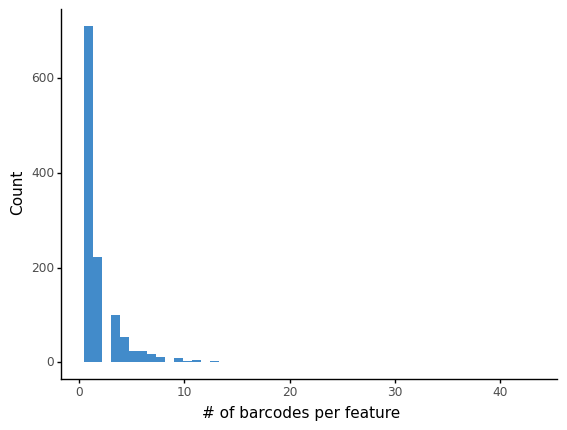

<ggplot: (8729784834383)>

In [93]:
(p9.ggplot(geneInfo, p9.aes('Feature'))
 + p9.geom_histogram(bins=50, fill='#428bca')
 + p9.theme_classic()
 + p9.ylab("Count")
 + p9.xlab("# of barcodes per feature"))


In [95]:
inocm.head()

barcode  count     mouse day     organ           Feature  \
1   AAAAAATCGCAGCCACT    760  inoculum  d0  inoculum  gene-SL1344_1343   
19  AAAAAATTCCAGCGTCA   1689  inoculum  d0  inoculum  gene-SL1344_3688   
55  AAAAACCCTTCTGCACC   2254  inoculum  d0  inoculum  gene-SL1344_2861   
73  AAAAACCGCTGGATGGC      0  inoculum  d0  inoculum  gene-SL1344_1742   
91  AAAAAGCTAGCTTTATC   2431  inoculum  d0  inoculum  gene-SL1344_0776   

   ShortName  
1       ssaJ  
19      rfaG  
55      sipA  
73      minC  
91      slrP

In [96]:
inoc_sum =inocm.groupby('Feature').agg({'count':['mean', 'std', 'count']})

In [101]:
inoc_sum.tail()

count                   
                       mean          std count
Feature                                       
gene-SL1344_RS27340   822.0  1162.483548     2
gene-SL1344_RS27480   935.0  1322.289681     2
gene-STnc1470           0.0          NaN     1
gene-STnc2130           0.0          NaN     1
gene-STnc440         3660.0          NaN     1

In [102]:
inocm[inocm.Feature == 'gene-SL1344_RS27340']

barcode  count     mouse day     organ              Feature  \
15337  ATCCCTACACGGAGTAG      0  inoculum  d0  inoculum  gene-SL1344_RS27340   
43957  TAACGGGTGACCACACC   1644  inoculum  d0  inoculum  gene-SL1344_RS27340   

            ShortName  
15337  SL1344_RS27340  
43957  SL1344_RS27340

In [111]:
print(f"After removal of unmapped barcodes there are {inocm.shape[0]} unique BC")
print(f"There are {inocm[inocm['count']==0].shape[0]} barcodes with 0 counts")
print("\n")
print("Removing barcodes with 0 counts")

After removal of unmapped barcodes there are 2457 unique BC
There are 903 barcodes with 0 counts


Removing barcodes with 0 counts


In [113]:
inocm2 = inocm[inocm["count"] >0]
inoc_sum2 =inocm2.groupby('Feature').agg({'count':['mean', 'std', 'count']})

In [100]:
inoc_sum[inoc_sum.index == 'gene-SL1344_4197']

count                   
                         mean          std count
Feature                                         
gene-SL1344_4197  2435.069767  2026.600172    43

In [115]:
inoc_sum2[inoc_sum2.index == 'gene-SL1344_4197']

count                  
                         mean         std count
Feature                                        
gene-SL1344_4197  2991.657143  1832.86497    35

In [117]:
inocm2[inocm2.Feature == 'gene-InvR']

barcode  count     mouse day     organ    Feature ShortName
51049  TGCTAAGAGCACATGTA   2125  inoculum  d0  inoculum  gene-InvR      InvR

Feature
gene-SL1344_4197          35
gene-SL1344_2855           9
gene-SL1344_2875           8
gene-SL1344_RS24485        7
gene-SL1344_3987           7
...                      ...
gene-SL1344_0511           1
gene-SL1344_3655           1
gene-SL1344_RS23865        1
gene-SL1344_2217           1
gene-SL1344_0580           1

[867 rows x 1 columns]

          Feature
count  867.000000
mean     1.792388
std      1.728924
min      1.000000
25%      1.000000
50%      1.000000
75%      2.000000
max     35.000000


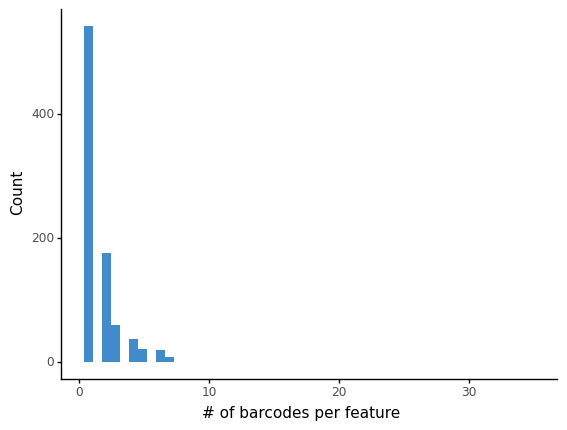

<ggplot: (8729784653120)>

In [120]:
geneInfo2 = pd.DataFrame(inocm2.Feature.value_counts())
print(geneInfo2.describe())
(p9.ggplot(geneInfo2, p9.aes('Feature'))
 + p9.geom_histogram(bins=50, fill='#428bca')
 + p9.theme_classic()
 + p9.ylab("Count")
 + p9.xlab("# of barcodes per feature"))

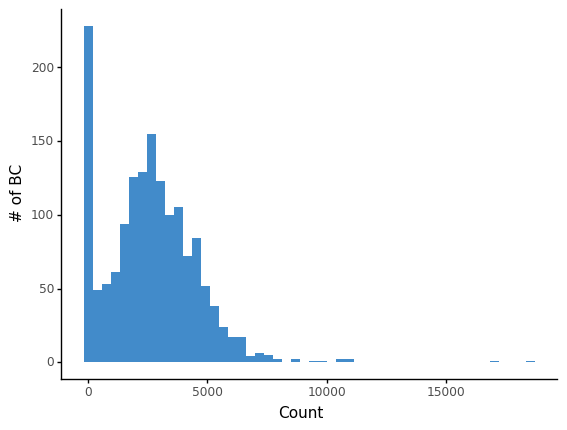

<ggplot: (8729784617207)>

In [127]:
(p9.ggplot(inocm2, p9.aes('count'))
 + p9.geom_histogram(bins=50, fill='#428bca')
 + p9.theme_classic()
 + p9.ylab("# of BC")
 + p9.xlab("Count"))

In [125]:
inocm2['count'].describe()

count     1554.000000
mean      2605.595882
std       1878.381654
min         10.000000
25%       1312.750000
50%       2541.000000
75%       3764.000000
max      18552.000000
Name: count, dtype: float64

In [66]:
fdf[fdf.Feature == 'gene-InvR']

index  count                mouse day     organ    Feature  \
65430  TGCTAAGAGCACATGTA   2355  unenriched_inoculum  d0  inoculum  gene-InvR   
65431  TGCTAAGAGCACATGTA   2125             inoculum  d0  inoculum  gene-InvR   
65432  TGCTAAGAGCACATGTA   1556                al960  d1     feces  gene-InvR   
65433  TGCTAAGAGCACATGTA   2535                al961  d1     feces  gene-InvR   
65434  TGCTAAGAGCACATGTA   2008                al962  d1     feces  gene-InvR   
65435  TGCTAAGAGCACATGTA   3649                al963  d1     feces  gene-InvR   
65436  TGCTAAGAGCACATGTA   3072                al964  d1     feces  gene-InvR   
65437  TGCTAAGAGCACATGTA   3186                al965  d1     feces  gene-InvR   
65438  TGCTAAGAGCACATGTA   1502                al966  d1     feces  gene-InvR   
65439  TGCTAAGAGCACATGTA   2951                al967  d1     feces  gene-InvR   
65440  TGCTAAGAGCACATGTA   2862                al960  d2     feces  gene-InvR   
65441  TGCTAAGAGCACATGTA   2529                al961  d2     feces  gene-InvR   
65442  TGCTAAGAGCACATGTA   1949                al962  d2     feces  gene-InvR   
65443  TGCTAAGAGCACATGTA   6024                al963  d2     feces  gene-InvR   
65444  TGCTAAGAGCACATGTA   3384                al964  d2     feces  gene-InvR   
65445  TGCTAAGAGCACATGTA   2500                al965  d2     feces  gene-InvR   
65446  TGCTAAGAGCACATGTA   1210                al966  d2     feces  gene-InvR   
65447  TGCTAAGAGCACATGTA   3530                al967  d2     feces  gene-InvR   

      ShortName  
65430      InvR  
65431      InvR  
65432      InvR  
65433      InvR  
65434      InvR  
65435      InvR  
65436      InvR  
65437      InvR  
65438      InvR  
65439      InvR  
65440      InvR  
65441      InvR  
65442      InvR  
65443      InvR  
65444      InvR  
65445      InvR  
65446      InvR  
65447      InvR